In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
from datetime import datetime
from datetime import date
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

pd.set_option('display.max_columns', None)


### Conts 

In [2]:
# Background graph style
sns.set(style="darkgrid")
sns.set(style="whitegrid")


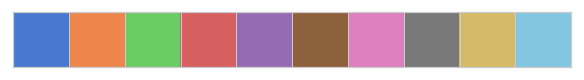

In [3]:
# ==============
# Chouse color
# ==============
sns.palplot(sns.color_palette("muted"))  # show color
sns.set_palette("muted") # for seaborn
colors = sns.color_palette("muted") # for pyplot

### Functions 

In [4]:
# ------------------------------- FUNCIONES ---------------------------------------- #

def woe(catvar,target, data):
    data_aggr = data.groupby([catvar,target]).size().reset_index()
    data_aggr.columns = [catvar,'target','numreg']
    
    # calculamos totales target
    non_event_total= np.sum(data_aggr[data_aggr.target==0]['numreg'])
    event_total = np.sum(data_aggr[data_aggr.target==1]['numreg']) 
    
    # pivoteamos data frame
    data_aggr = data_aggr.pivot(index=catvar, columns='target', values='numreg').reset_index()
    data_aggr.columns = [catvar,'non_event','event']
    
    # calculamos rate de event
    data_aggr['event_rate'] = data_aggr['event']/event_total
    data_aggr['non_event_rate'] = data_aggr['non_event']/non_event_total
    
    # calculamos woe
    data_aggr['woe'] = np.log(data_aggr['event_rate']/data_aggr['non_event_rate'])
    
    # calculamos IV
    data_aggr['rate_diff'] = data_aggr['event_rate'] - data_aggr['non_event_rate']
    data_aggr['information_value'] = data_aggr['rate_diff']*data_aggr['woe']
    #data_aggr['IV'] = data_aggr['IV'].sum()
    
    
    return data_aggr[[catvar,'woe','information_value','event_rate','non_event_rate']]

In [5]:
def info_value(woe_data):
    iv = woe_data['information_value'].sum()
    predictive_power = ""
    if iv < 0.02:
        predictive_power = "useless for prediction"
    elif iv >= 0.02 and iv < 0.1:
        predictive_power = "weak predictor"
    elif iv >= 0.1 and iv < 0.3:
        predictive_power = "medium predictor"
    elif iv >= 0.3 and iv < 0.5:
        predictive_power = "strong predictor"
    else:
        predictive_power = "suspicious predictor"
        
    return iv,predictive_power

In [6]:
def barprop(yvalue, xvalue, stitle, size, data):
    table=pd.crosstab(data[xvalue],data[yvalue])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.figure(figsize=size)
    
    if len(stitle)==0: # default title
        stitle = "Proportion bar graph"
    
    plt.title(stitle)
    plt.xlabel(xvalue)
    plt.ylabel(yvalue)
    plt.legend(train[yvalue].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pass

In [7]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

In [8]:
# =========================
#  Histogram
# =========================
def simpleHistGraph(numvar,  data, bins=10):
    g = data[numvar].hist(bins=bins)
    g.set_title(numvar +" distribucion ")
    pass

In [9]:
def countBarPlot(catvar, data, scale="linear", orient="h", rot=0, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    g = sns.countplot(x = catvar, data=data, orient=orient)
    loc, labels = plt.xticks()
    g.set_xticklabels(labels, rotation=rot)
    g.set_yscale(scale)
    
    g.set_title("Number of cases by " + catvar.upper())
    plt.show()
    pass

### Load Data

In [10]:
# Load Train Data
rawdata = pd.read_csv('../data/raw/train.csv',sep=';')

### Describe Data

In [11]:
rawdata.shape

(256913, 36)

In [12]:
rawdata.head()

,fecha_venta,id_pos,unidades,canal,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
0,2012-10-01,8495,4,MAXIKIOSCO,14.0,49367.31,65176.325,7981.955,6.695,6.26,5.835,5.105,6.48,6.505,6.32,5.725,6.395,6.465,7.08,6.61,5.885,5.44,4.26,3.48,2.91,2.555,16.75,0.61,32.42,5.35,0.18,1.16,0.0,0.145,3.01,152962.485
1,2012-11-10,8495,1,MAXIKIOSCO,14.0,49367.31,65176.325,7981.955,6.695,6.26,5.835,5.105,6.48,6.505,6.32,5.725,6.395,6.465,7.08,6.61,5.885,5.44,4.26,3.48,2.91,2.555,16.75,0.61,32.42,5.35,0.18,1.16,0.0,0.145,3.01,152962.485
2,2012-12-03,8495,1,MAXIKIOSCO,14.0,49367.31,65176.325,7981.955,6.695,6.26,5.835,5.105,6.48,6.505,6.32,5.725,6.395,6.465,7.08,6.61,5.885,5.44,4.26,3.48,2.91,2.555,16.75,0.61,32.42,5.35,0.18,1.16,0.0,0.145,3.01,152962.485
3,2012-12-13,8495,1,MAXIKIOSCO,14.0,49367.31,65176.325,7981.955,6.695,6.26,5.835,5.105,6.48,6.505,6.32,5.725,6.395,6.465,7.08,6.61,5.885,5.44,4.26,3.48,2.91,2.555,16.75,0.61,32.42,5.35,0.18,1.16,0.0,0.145,3.01,152962.485
4,2012-12-14,8495,2,MAXIKIOSCO,14.0,49367.31,65176.325,7981.955,6.695,6.26,5.835,5.105,6.48,6.505,6.32,5.725,6.395,6.465,7.08,6.61,5.885,5.44,4.26,3.48,2.91,2.555,16.75,0.61,32.42,5.35,0.18,1.16,0.0,0.145,3.01,152962.485


In [13]:
rawdata.sample(n=5)

,fecha_venta,id_pos,unidades,canal,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
178843,2012-12-21,3903,4,ALMACEN,42.0,51068.53167,68705.91667,15540.726670,6.060000,5.495000,4.838333,5.111667,7.730000,8.245000,7.315000,6.128333,6.030000,6.140000,6.961667,6.703333,6.025000,5.290000,4.050000,3.098333,2.291667,2.486667,17.280000,0.918333,27.546667,6.635000,0.716667,2.491667,0.065000,0.411667,4.005000,241503.4733
53118,2012-11-14,5941,1,ALMACEN,47.0,51563.56444,65137.94111,8824.391111,6.114444,6.021111,5.766667,9.858889,9.270000,6.446667,5.846667,5.345556,5.548889,5.488889,5.766667,6.176667,6.250000,5.823333,4.137778,2.803333,1.850000,1.484444,16.725556,1.164444,26.790000,7.307778,0.238889,1.595556,0.006667,0.062222,2.074444,192517.9600
217941,2012-12-24,14394,2,ALMACEN,38.0,54361.66571,67845.46857,13710.388570,7.125714,6.880000,6.537143,6.165714,7.732857,8.330000,8.372857,6.795714,6.727143,6.762857,6.718571,6.082857,4.718571,3.665714,2.525714,1.915714,1.527143,1.411429,18.018571,0.841429,31.045714,6.451429,0.182857,4.057143,0.490000,0.055714,1.790000,182416.4814
24954,2013-12-13,5133,2,ALMACEN,7.0,69310.21000,100348.86000,18032.360000,2.310000,1.920000,1.660000,3.820000,12.390000,17.360000,13.410000,9.210000,8.570000,7.590000,7.420000,6.040000,3.930000,1.930000,0.960000,0.710000,0.410000,0.390000,24.490000,2.670000,18.560000,12.260000,0.370000,5.320000,0.410000,0.120000,6.640000,224319.0500
185258,2012-12-09,11193,1,ALMACEN,4.0,70715.09750,93652.46250,2488.485000,4.292500,5.837500,6.447500,5.790000,4.805000,5.085000,4.295000,4.385000,5.775000,6.892500,7.657500,8.165000,8.342500,7.492500,5.200000,3.625000,2.787500,3.117500,22.217500,4.272500,29.415000,11.532500,0.145000,0.650000,0.122500,0.055000,2.067500,261513.9925


In [14]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256913 entries, 0 to 256912
Data columns (total 36 columns):
fecha_venta             256913 non-null object
id_pos                  256913 non-null int64
unidades                256913 non-null int64
canal                   256913 non-null object
competidores            256356 non-null float64
ingreso_mediana         256903 non-null float64
ingreso_promedio        256903 non-null float64
densidad_poblacional    256895 non-null float64
pct_0a5                 256913 non-null float64
pct_5a9                 256895 non-null float64
pct_10a14               256888 non-null float64
pct_15a19               256913 non-null float64
pct_20a24               256895 non-null float64
pct_25a29               256895 non-null float64
pct_30a34               256895 non-null float64
pct_35a39               256895 non-null float64
pct_40a44               256895 non-null float64
pct_45a49               256895 non-null float64
pct_50a54               256895 

In [15]:
rawdata.describe(include=['O']) # category data

,fecha_venta,canal
count,256913,256913
unique,276,4
top,2013-12-24,ALMACEN
freq,9368,255735


In [16]:
rawdata.describe() # numerical data

,id_pos,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
count,256913.000000,256913.000000,256356.000000,256903.000000,256903.000000,256895.000000,256913.000000,256895.000000,256888.000000,256913.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,256895.000000,2.569130e+05
mean,7971.327765,2.379553,26.474555,55140.653968,72454.863529,11446.107853,6.019177,6.101146,6.051763,6.423728,7.710667,7.166487,6.838250,5.934228,6.282257,6.321869,6.931953,6.703141,5.816150,4.885625,3.643925,2.694805,2.102916,2.371533,18.050765,1.314333,28.587622,7.704098,0.616347,2.227237,1.399270,0.139689,3.582423,2.168429e+05
std,4717.759437,2.392814,45.569646,14856.171320,18949.005645,15896.466503,1.218060,1.176335,1.192586,1.846806,3.730536,2.019631,1.464992,0.939371,0.867020,0.898555,1.002862,1.074225,1.187385,1.310157,1.185718,0.943695,0.827224,1.237368,6.039700,1.026482,6.774172,3.462295,0.860146,2.783029,5.056594,0.337745,3.891405,1.195759e+05
min,3142.000000,-29.000000,0.000000,15519.520000,22629.590000,0.050000,0.000000,0.000000,0.000000,0.120000,0.270000,0.320000,0.350000,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.950000,0.000000,3.590000,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4961.000000,1.000000,4.000000,45748.110000,60141.000000,4511.755000,5.410000,5.523750,5.471667,5.632500,6.010000,6.033333,6.080000,5.470000,5.868750,5.896667,6.480000,6.190000,5.245000,4.213333,3.050000,2.208000,1.656667,1.694286,14.210000,0.685000,24.686667,5.410000,0.157500,0.610000,0.000000,0.000000,1.618571,1.436532e+05
50%,6699.000000,2.000000,14.000000,53927.487690,70592.670000,8439.440000,5.993333,6.090571,6.066667,6.205556,6.981667,6.993333,6.778000,5.936667,6.310000,6.334615,6.940000,6.691429,5.726000,4.747500,3.515152,2.600000,2.027500,2.224000,18.130000,1.140000,28.067500,7.470000,0.407500,1.552500,0.071250,0.045000,2.546667,1.948627e+05
75%,9492.000000,3.000000,32.000000,62119.430000,81254.190000,12734.917190,6.595833,6.700000,6.690000,6.840000,8.261000,7.991429,7.490000,6.390000,6.730000,6.755000,7.432000,7.230000,6.300000,5.370000,4.050000,3.030000,2.402000,2.780000,21.374286,1.667143,32.230000,9.390000,0.757500,2.820000,0.508000,0.138571,4.123810,2.575474e+05
max,63432.000000,59.000000,2607.000000,165644.920000,201504.010000,278007.800000,19.320000,20.380000,15.280000,41.550000,73.540000,26.740000,18.480000,16.660000,14.980000,13.870000,14.243333,13.840000,17.360000,20.800000,19.670000,16.220000,17.300000,25.800000,46.700000,13.900000,57.420000,30.320000,17.890000,35.970000,72.970000,6.490000,80.960000,1.710129e+06


In [17]:
print(rawdata.nunique())

fecha_venta               276
id_pos                  11853
unidades                   58
canal                       4
competidores              281
ingreso_mediana         11668
ingreso_promedio        11671
densidad_poblacional    11656
pct_0a5                  4600
pct_5a9                  4602
pct_10a14                4638
pct_15a19                4823
pct_20a24                5768
pct_25a29                5444
pct_30a34                4933
pct_35a39                4164
pct_40a44                4025
pct_45a49                4015
pct_50a54                4214
pct_55a59                4317
pct_60a64                4445
pct_65a69                4538
pct_70a74                4341
pct_75a79                4016
pct_80a84                3778
pct_85ainf               4337
pct_bachelors            7829
pct_doctorados           4058
pct_secundario           8016
pct_master               6521
pct_bicicleta            3357
pct_omnibus              5237
pct_subtes               3597
pct_taxi  

In [18]:
rawdata['fecha_venta'] = pd.to_datetime(rawdata['fecha_venta'])

In [19]:
rawdata['fecha_venta_norm'] = rawdata['fecha_venta'].apply(lambda x : date(x.year,x.month,1))

### Explore Numerical Data

#### unidades (target)
- Se observan valores negativos. Debe ser un error de carga (imputar o borrar). Puede que tambien se deba a debitos de unidades (para compensar unidades vendidas cargadas de mas)
- La mediana se encuentra entre 1 y 2 unidades.
- Hay muchos outliers (se deberian tratar o no). NO son valores inusuales.

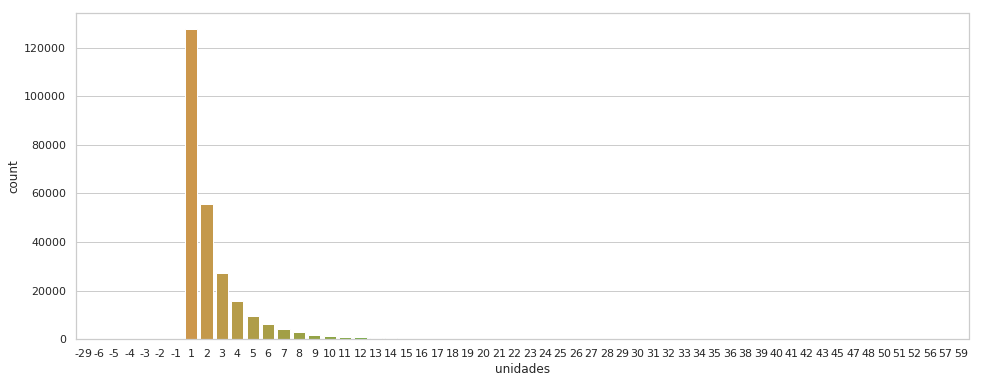

In [28]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(16, 6))
sns.countplot(x='unidades', data=rawdata)
pass

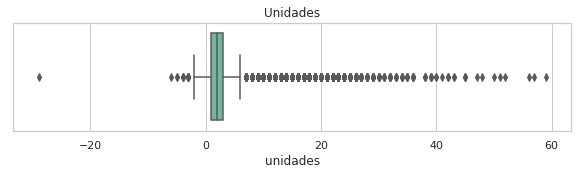

In [71]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="unidades", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de las unidades se conserva relativamente en todos los periodos.
- Se observa que la mayoria de los outliers se encuentran en los meses fin de año (11 y 12) por lo cual podemos afirmar que estos valores no son necesariamente outliers sino una mayor cantidad de ventas para esos periodos.
- Quizas se deberia hacer un modelo teniendo en cuenta esos periodos yo que los otros presenta valores estacionales diferentes al periodo que hay que scorear.

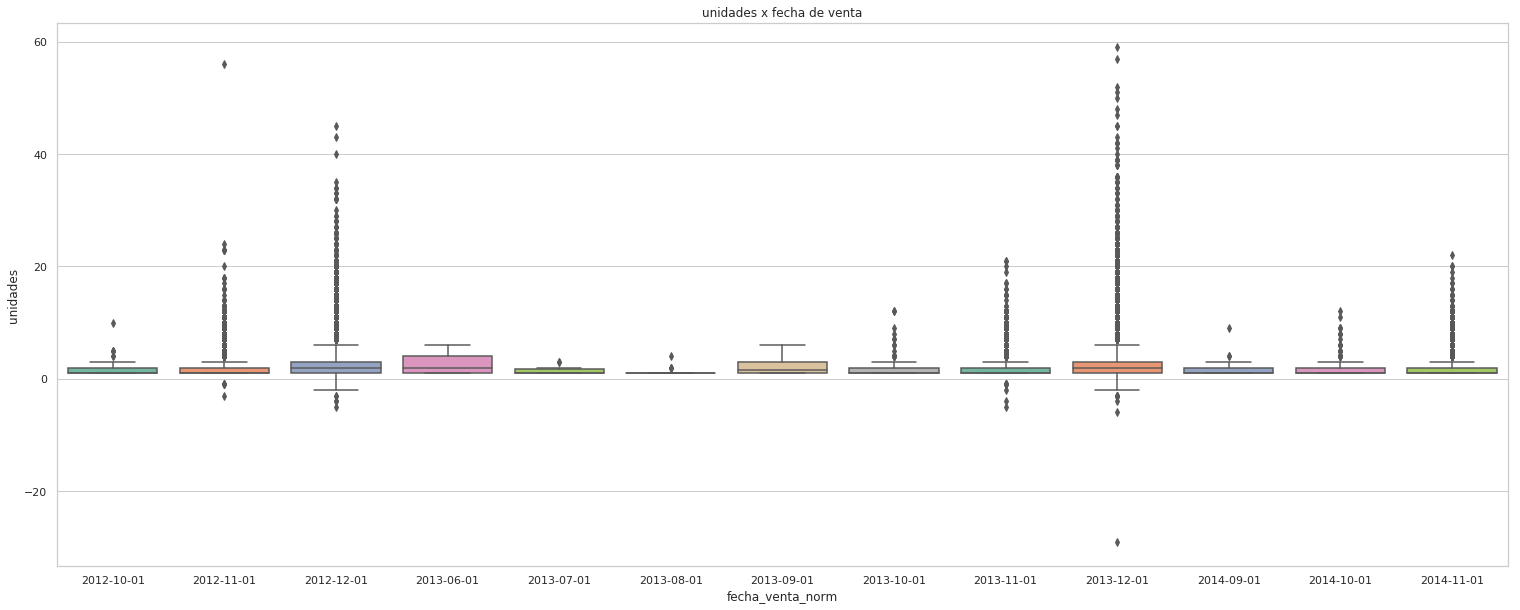

In [57]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_venta_norm", y="unidades", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("unidades x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- El numero de unidades vendidas se mantiene en la media cuando se lo analiza por el tipo de canal.
- El mayor numero de unidades aparece para el canal 'ALMACEN'
- Hay 79 pos con dos canales asignados. Ver si es un erorr o si se debe a un cambio de categoria de canal en el tiempo

In [38]:
canal_aggr = rawdata.groupby('id_pos').canal.nunique().reset_index()
canal_aggr.columns = ['id_pos','num_canales']

In [41]:
len(canal_aggr[canal_aggr.num_canales > 1])

79

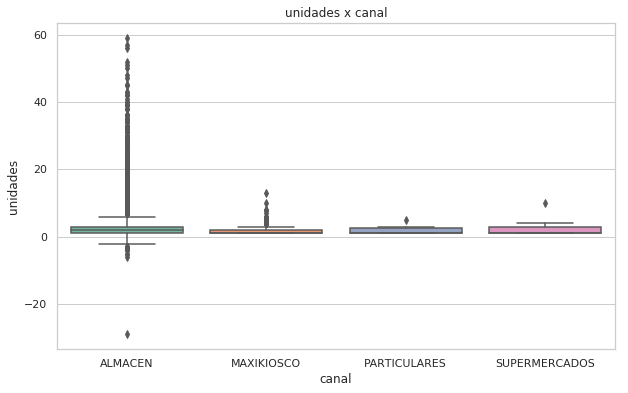

In [20]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="canal", y="unidades", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('canal')) # DataFrame, array, or list of arrays, optional
ax.set_title("unidades x canal")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La mayoria de las trx ocurren en los meses festivos 11 y 12 de cada año. No se observa casi nada de activadad en los meses restantes


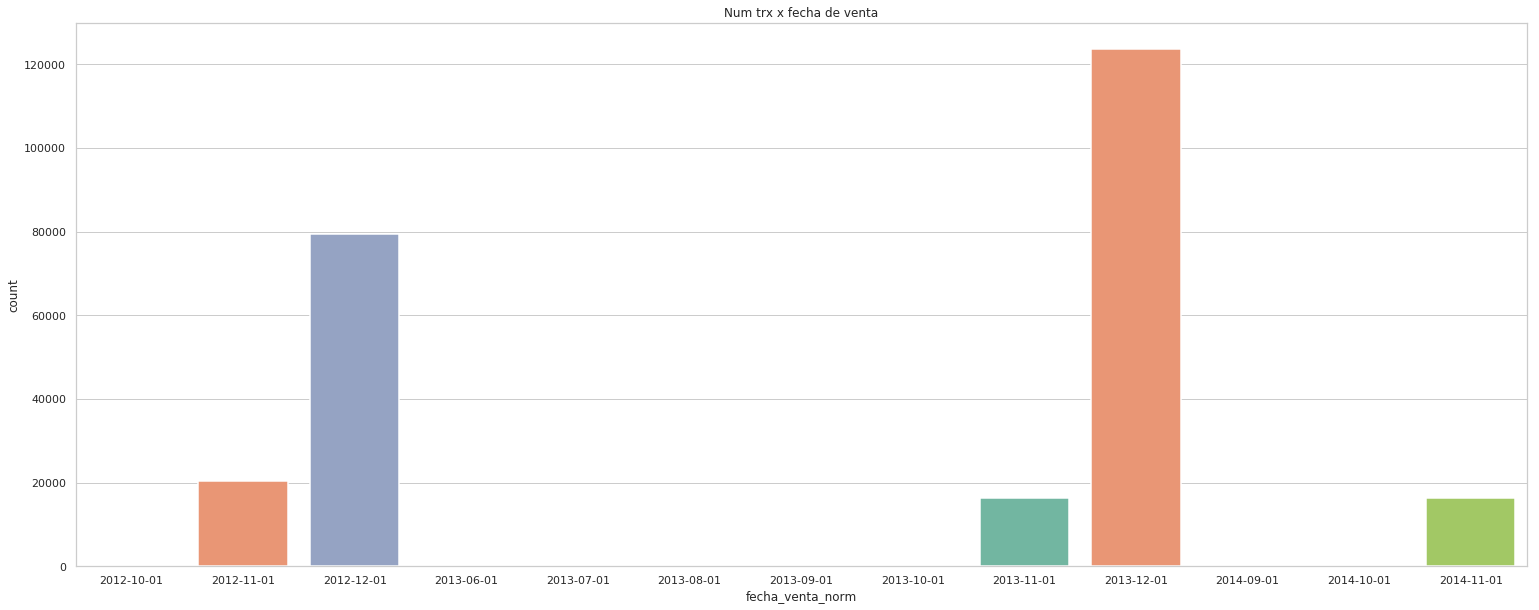

In [24]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.countplot(x="fecha_venta_norm",           linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm'))
ax.set_title("Num trx x fecha de venta")
pass

#### Unidades totales (target)
- Corresponde a la suma da unidades de cada pos en cada periodo (mes/año)
- La mediana se encuentra en 10
- La mayor variacion se ven en los meses festivos , en especial el mes 12, el cual tambien presenta el mayor numero de outliers.

In [25]:
rawdata_aggr = rawdata.groupby(['id_pos','fecha_venta_norm']).unidades.sum().reset_index()

In [33]:
rawdata_aggr['fecha_venta_norm'] = pd.to_datetime(rawdata_aggr.fecha_venta_norm)

In [37]:
rawdata_aggr[rawdata_aggr.fecha_venta_norm.dt.month.isin([12])].describe()

,id_pos,unidades
count,18601.000000,18601.000000
mean,9816.139132,27.745766
std,5403.079273,25.052812
min,3142.000000,1.000000
25%,5779.000000,10.000000
50%,8454.000000,19.000000
75%,13264.000000,40.000000
max,63432.000000,252.000000


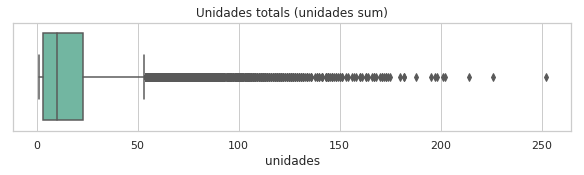

In [26]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="unidades", orient="h", linewidth=1.5, palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata_aggr) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades totals (unidades sum)")
pass

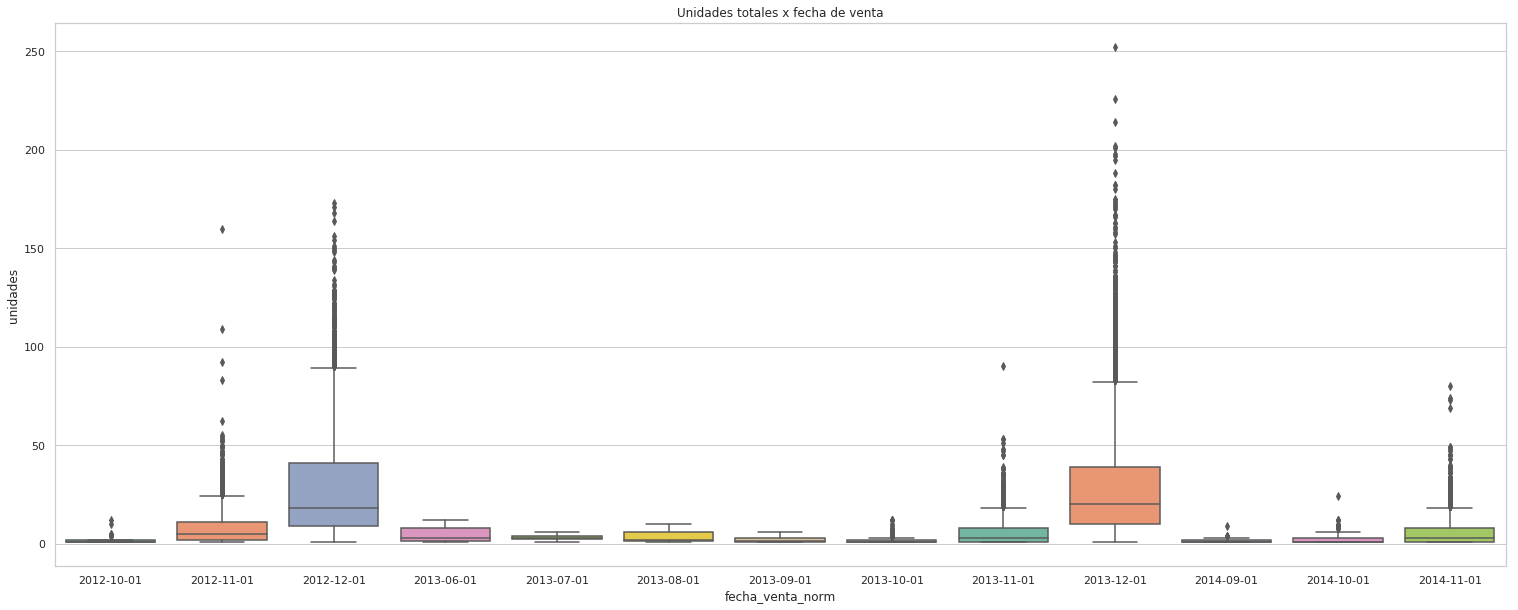

In [27]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_venta_norm", y="unidades", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata_aggr.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades totales x fecha de venta")
pass

#### competidores
- Los valores son elevados. Se observan muchos outliers que parecieran poseer valores que no corresponden a la metrica

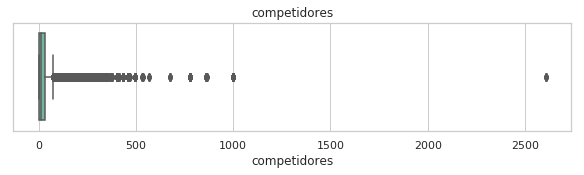

In [70]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="competidores", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("competidores")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de las unidades se conserva en todos los periodos a exepcion de los periodos cercanos a fin de año donde se observan la mayoria de los outliers. Esto puede deberse a que en esos periodos, al ser los de mayor consumo, aparecen mas puestos temporales.

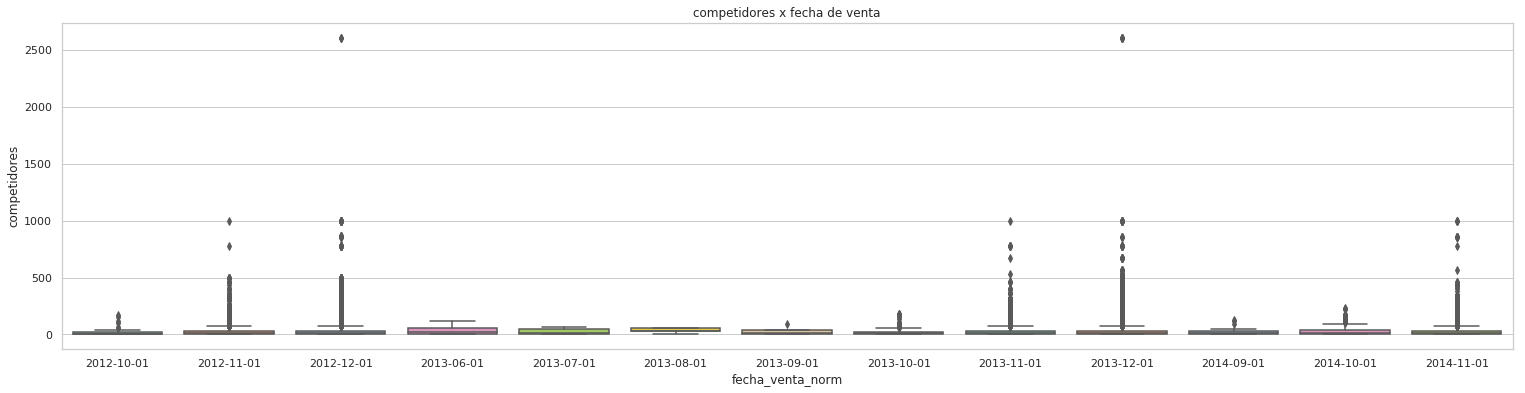

In [48]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="competidores", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("competidores x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### ingreso_mediana
- Los valores se encuentran entre 40000 y 60000
- Se presentan outliers con valores mayor a 100000. Son valores posibles o reales
- Pareciera estar expresado en pesos

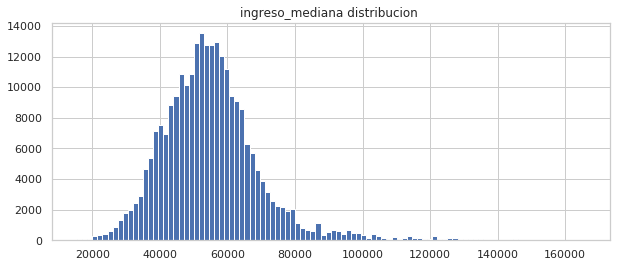

In [60]:
plt.figure(figsize=(10, 4))
simpleHistGraph('ingreso_mediana',rawdata, bins=100)

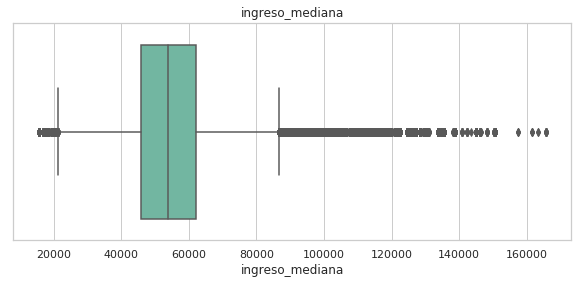

In [54]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x="ingreso_mediana", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_mediana")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion del ingreso medio se mantiene en los diferentes periodos. Lo cual resulta extraño si se considera el factor inflacionario.

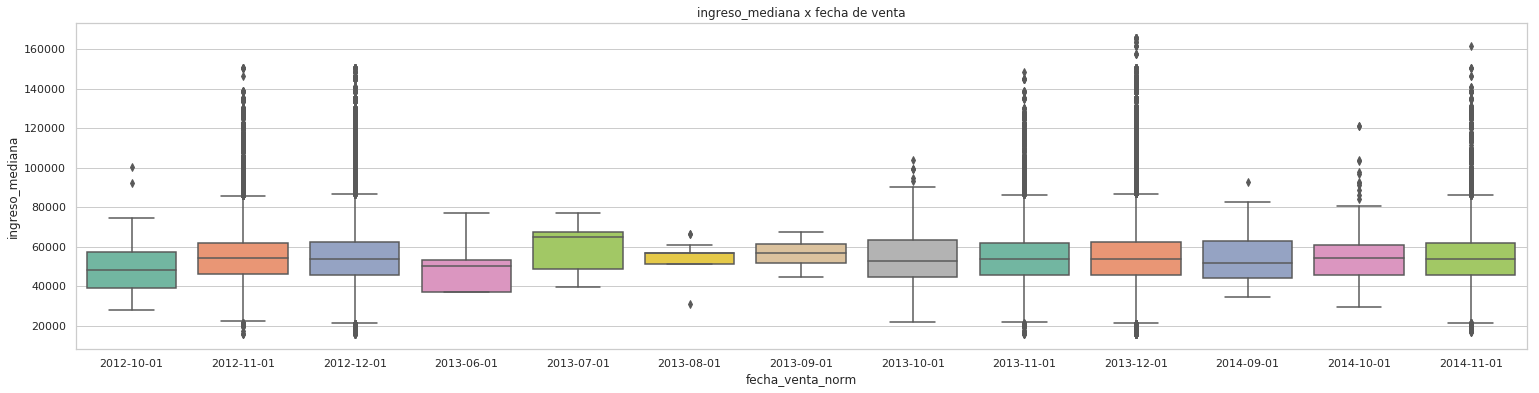

In [55]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="ingreso_mediana", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_mediana x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### ingreso_promedio
- Los valores se encuentran entre 60000 y 75000
- Se presentan outliers con valores mayor a 100000. Son valores posibles o reales
- Pareciera estar expresado en pesos
- presentan distribucion similar a ingreso_mediana

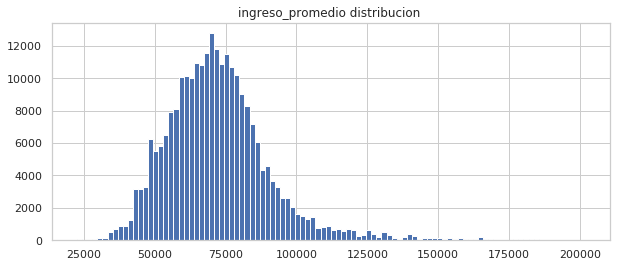

In [61]:
plt.figure(figsize=(10, 4))
simpleHistGraph('ingreso_promedio',rawdata, bins=100)

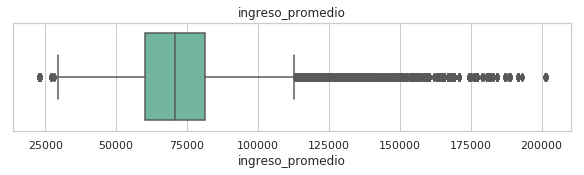

In [69]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="ingreso_promedio", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_promedio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion del ingreso medio se mantiene relativamente en los diferentes periodos, aun que se observa variaciones, y mas si se lo compara con el ingreso_mediana, la cual no varia tanto debido a su comportamiento de no ser tan influido por los outliers.
- Como esta variable es mas suseptible a ouliers y esta correlacionada con ingreso_mediana, no se deberia considerar.

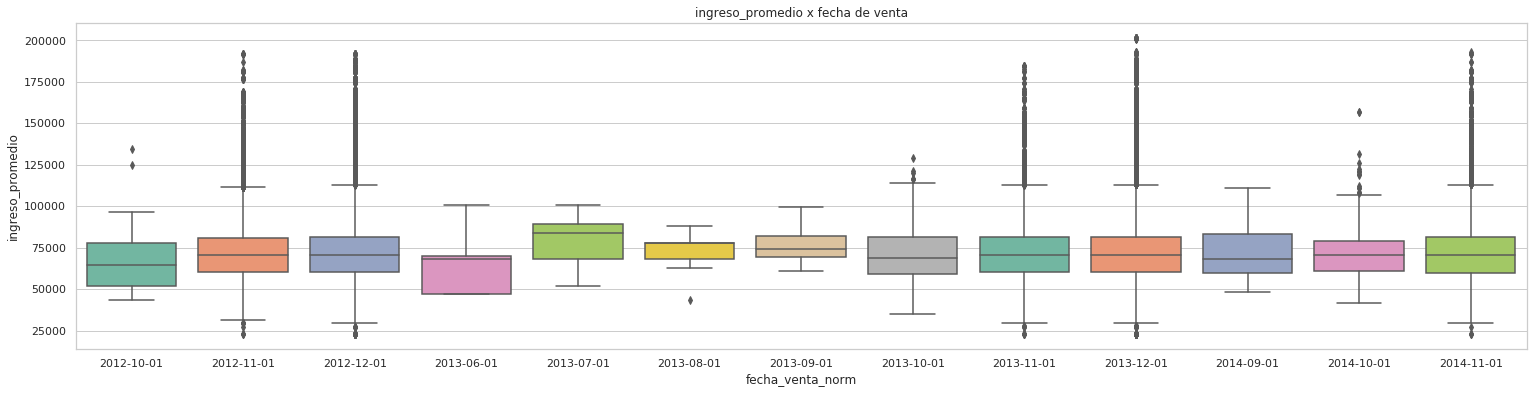

In [64]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="ingreso_promedio", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_promedio x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### densidad_poblacional
- Los valores se encuentran entre 40000 y 60000


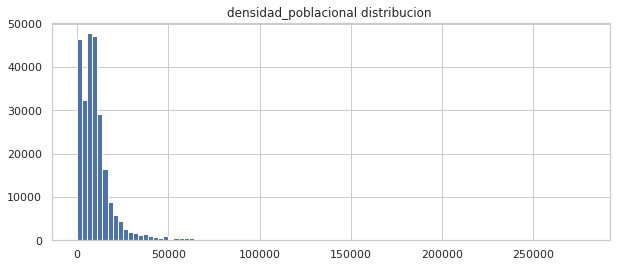

In [65]:
plt.figure(figsize=(10, 4))
simpleHistGraph('densidad_poblacional',rawdata, bins=100)

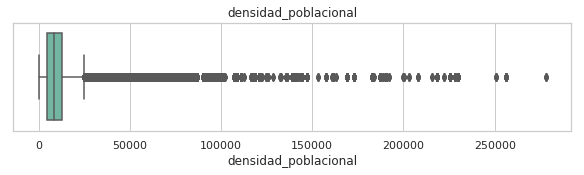

In [68]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="densidad_poblacional", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("densidad_poblacional")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion poblacional se mantiene en los diferentes periodos

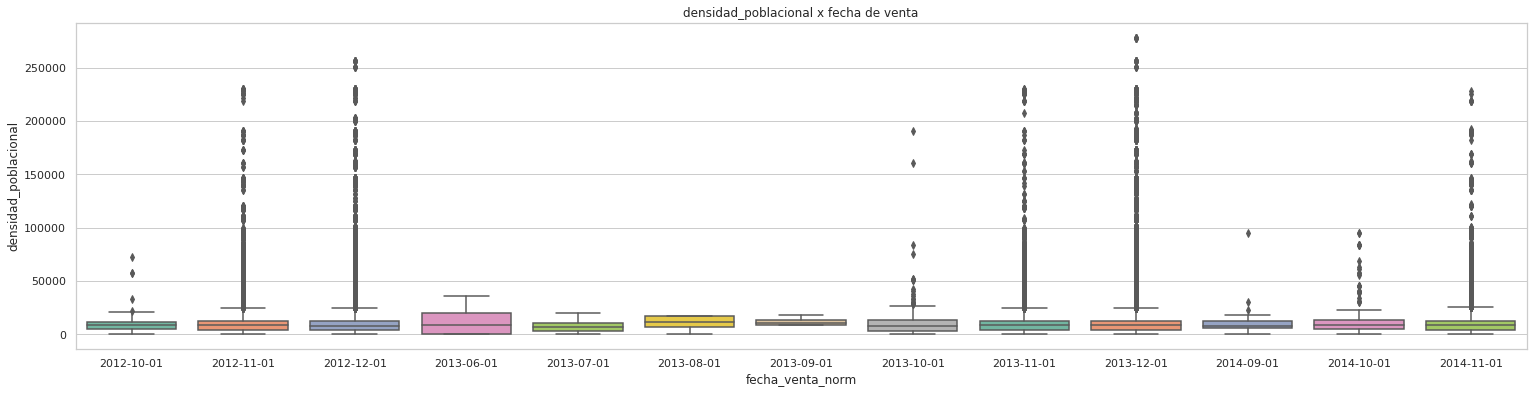

In [67]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="densidad_poblacional", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("densidad_poblacional x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_bachelors


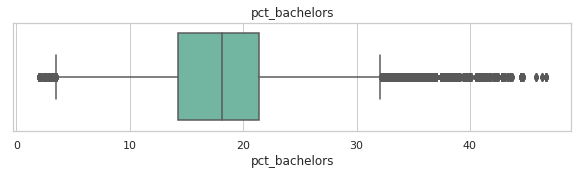

In [29]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_bachelors", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bachelors")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de pct_bachelors varia entre periodos
- La distribucion se conserva para los periodos 11 y 12

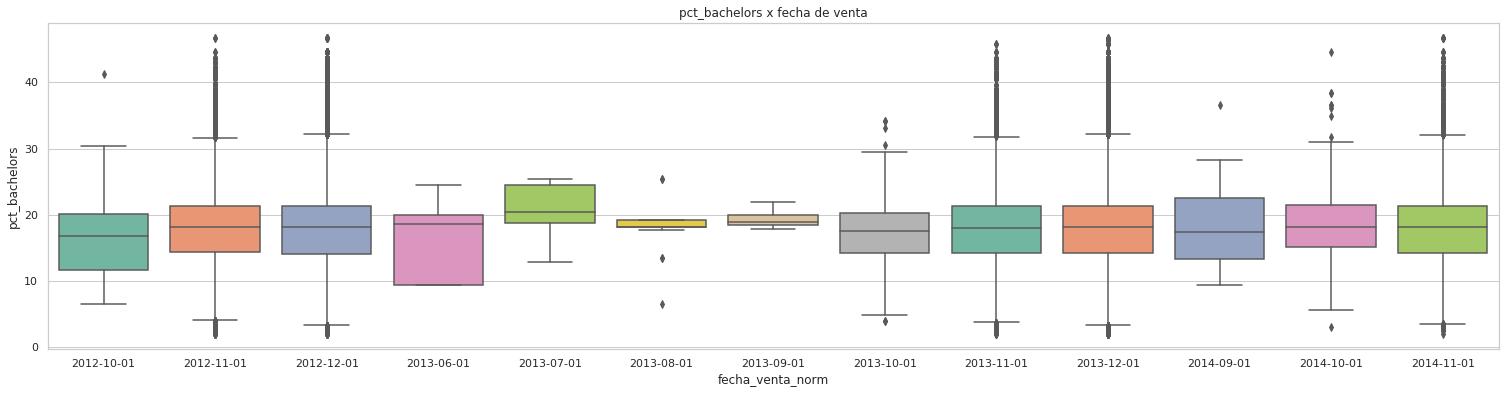

In [30]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_bachelors", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bachelors x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_doctorados
- Los valores se encuentran distribuidos entre valores bajos.

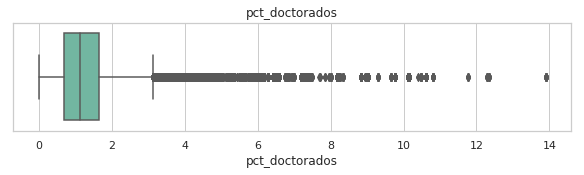

In [31]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_doctorados", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_doctorados")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de pct_doctorados se mantiene en la mayoria de los periodos a execpcion de los periodos 6, 7, 8, 9 de 2013
- La distribucion se conserva para los periodos 11 y 12

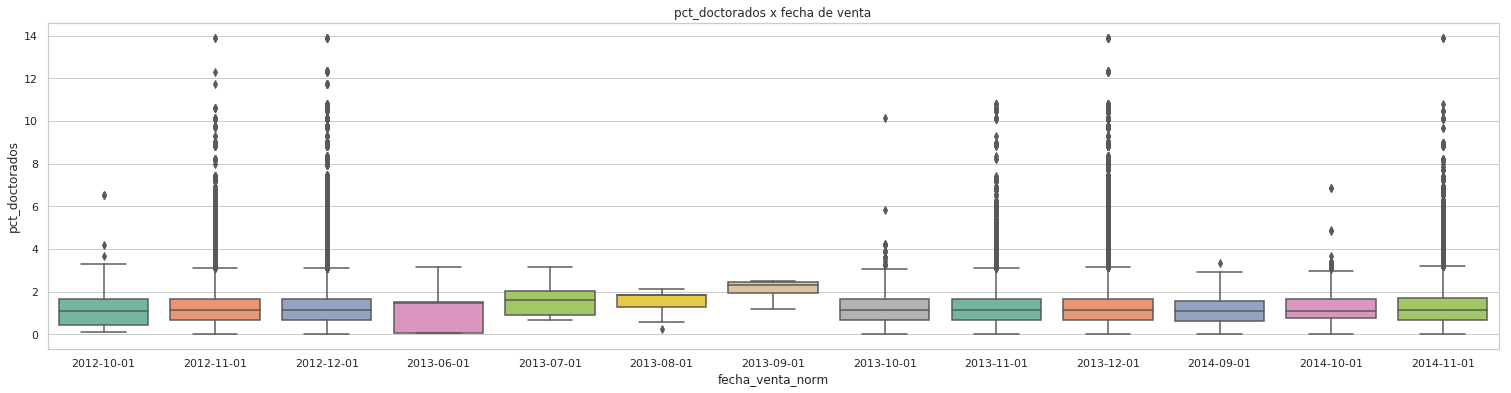

In [32]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_doctorados", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_doctorados x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_secundario


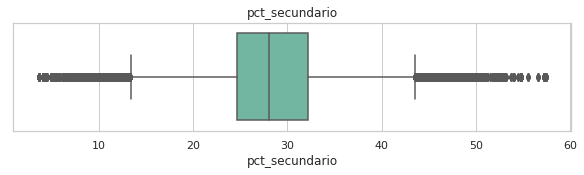

In [33]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_secundario", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_secundario")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

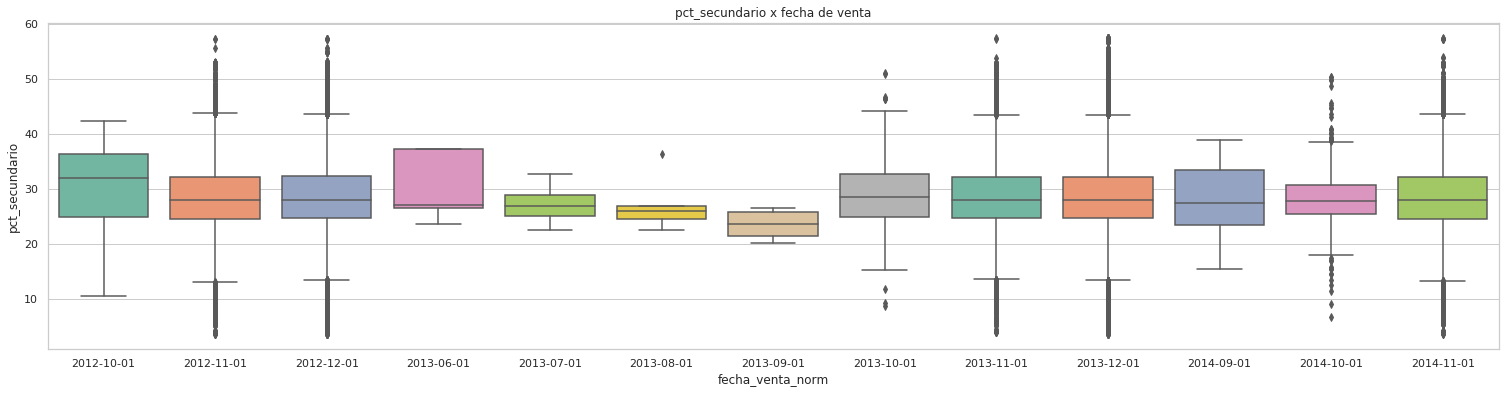

In [34]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_secundario", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_secundario x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_master


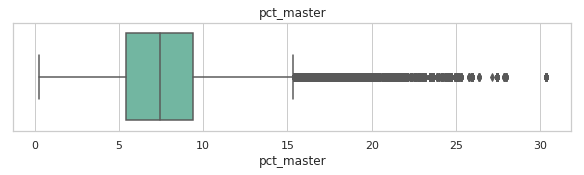

In [35]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_master", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_master")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

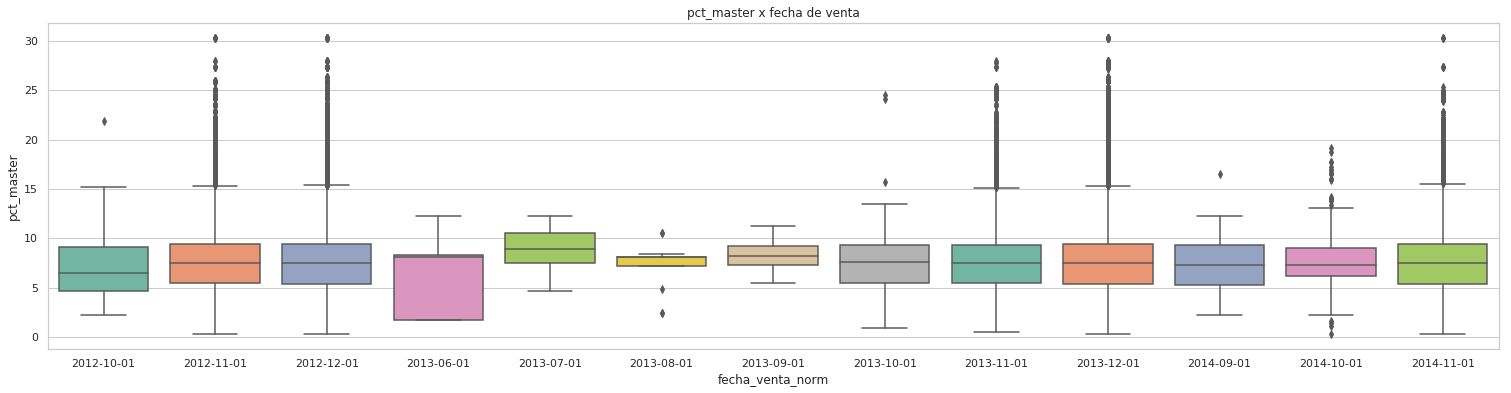

In [36]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_master", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_master x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_bicicleta


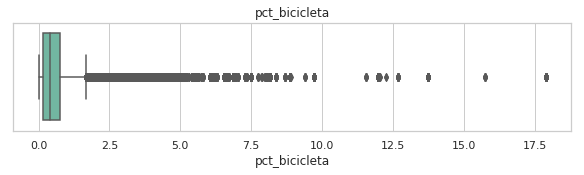

In [37]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_bicicleta", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bicicleta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

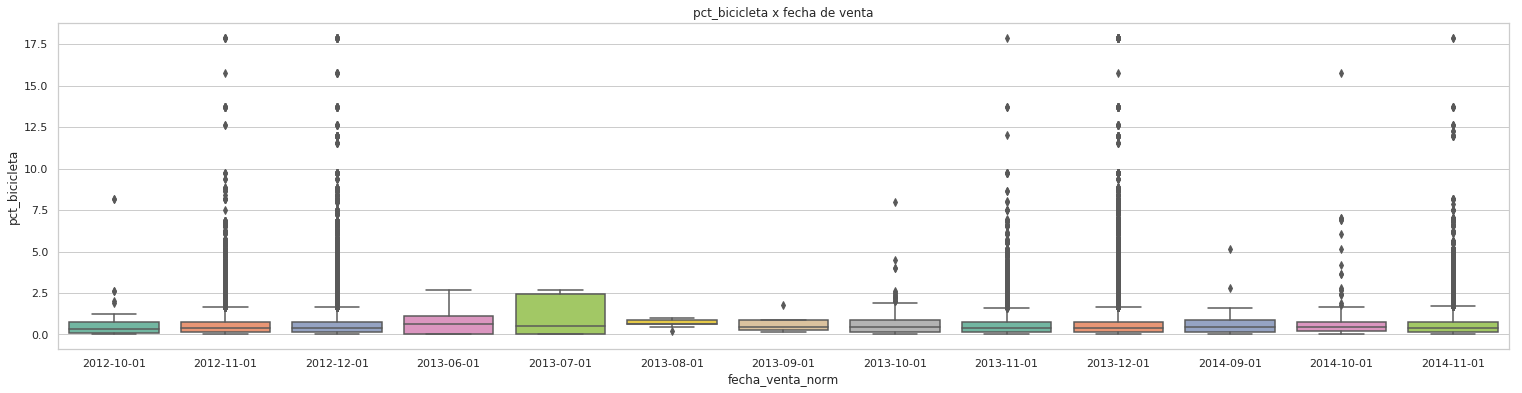

In [38]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_bicicleta", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bicicleta x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_omnibus


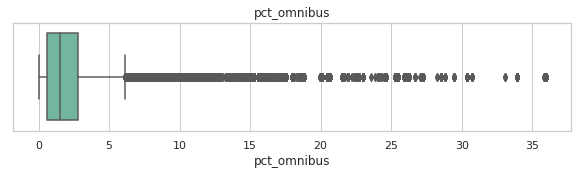

In [39]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_omnibus", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_omnibus")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

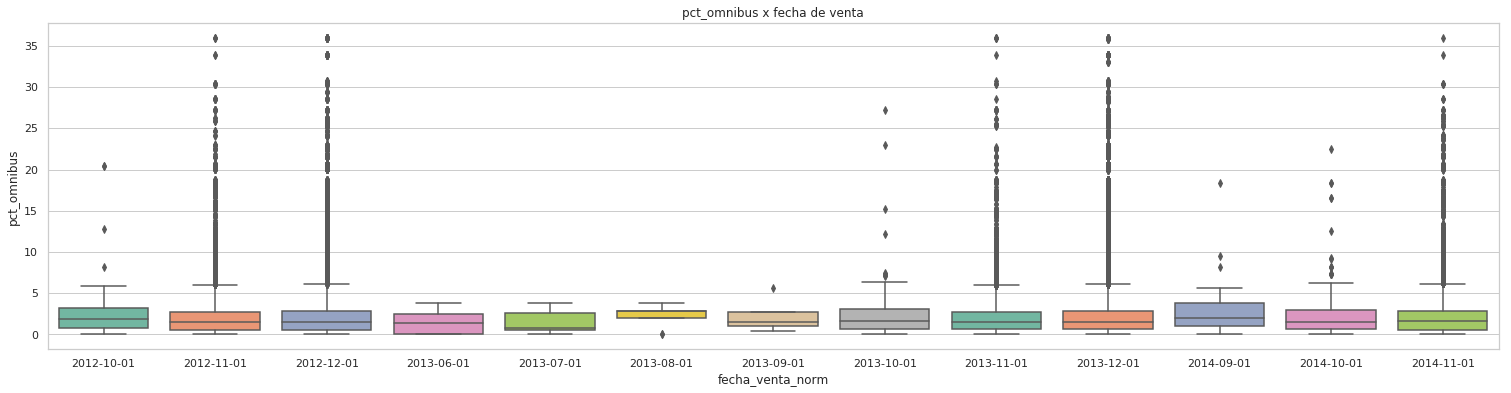

In [40]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_omnibus", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_omnibus x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_subtes

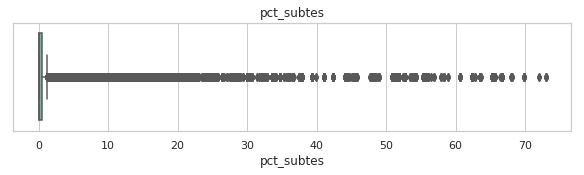

In [41]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_subtes", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_subtes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

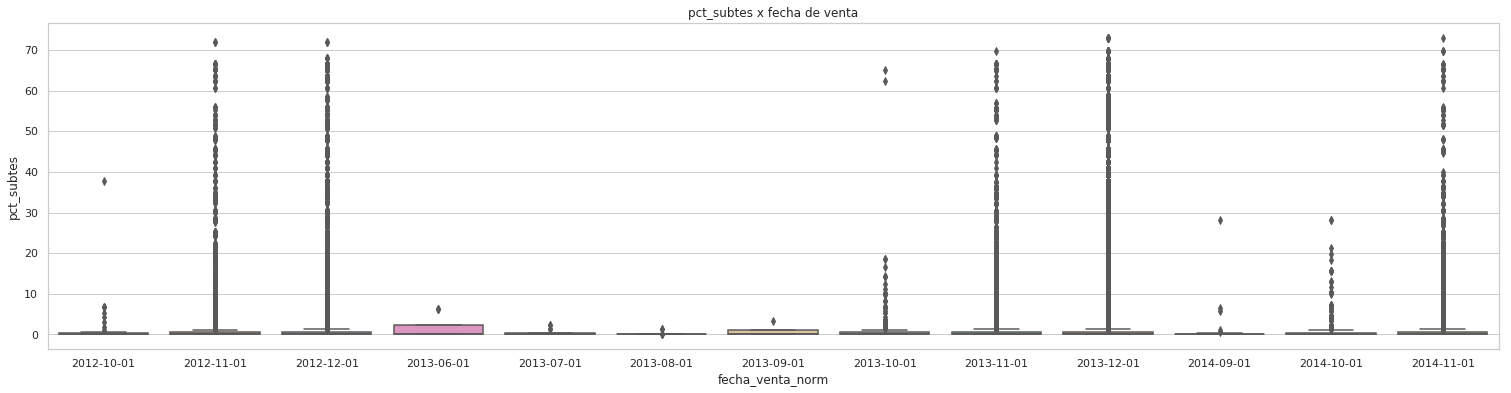

In [42]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_subtes", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_subtes x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_taxi


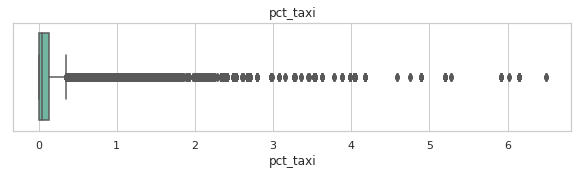

In [43]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_taxi", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_taxi")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

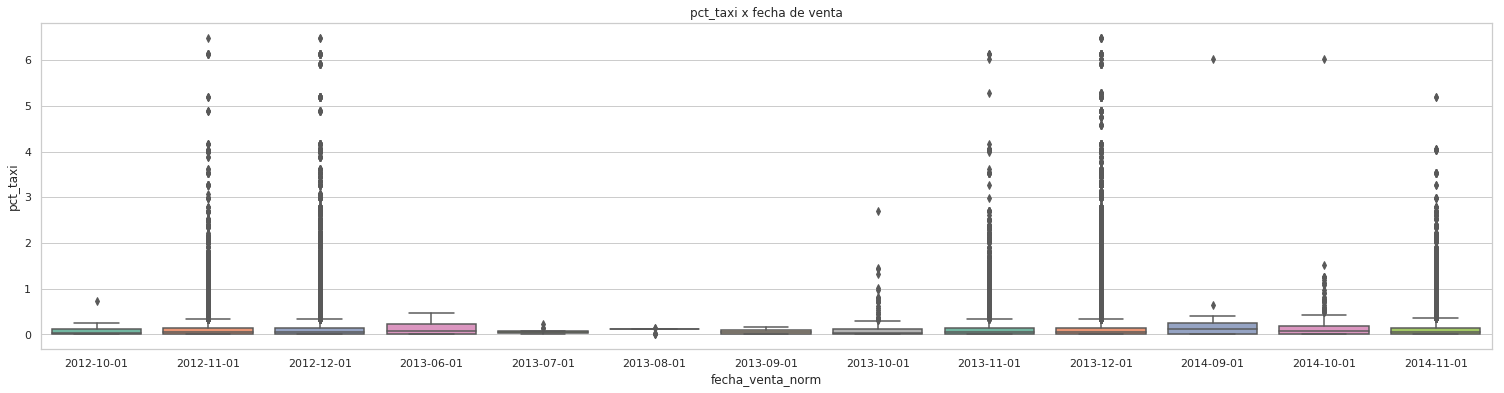

In [44]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_taxi", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_taxi x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_caminata


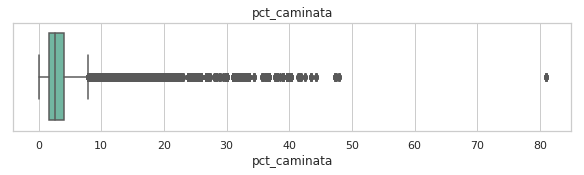

In [45]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_caminata", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_caminata")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

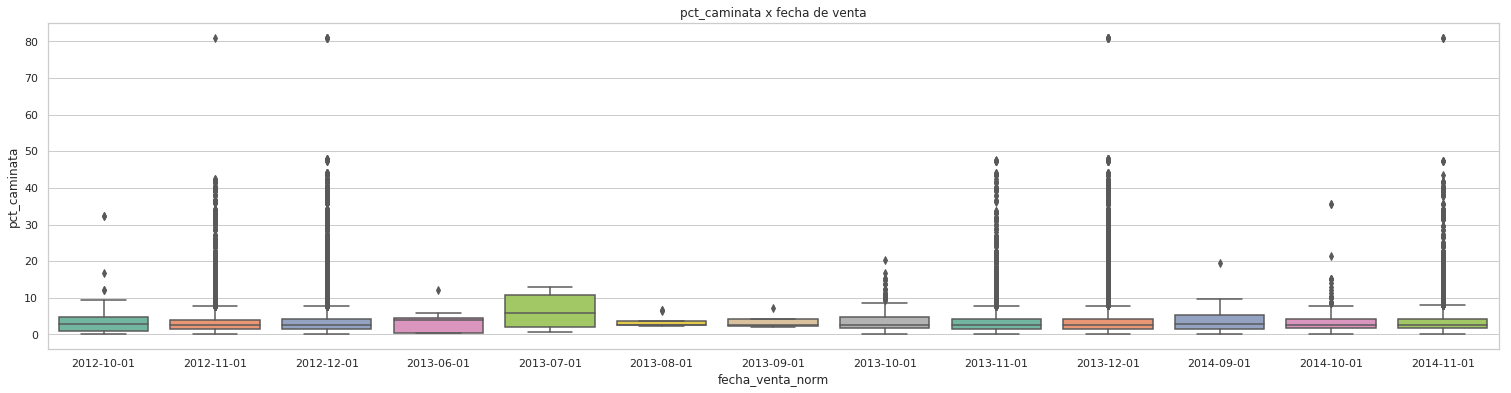

In [46]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_caminata", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_caminata x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### mediana_valor_hogar


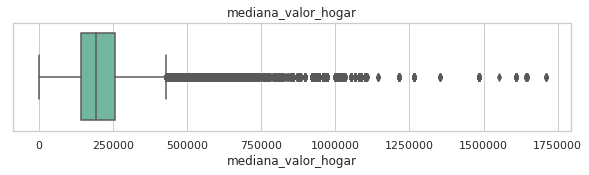

In [47]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="mediana_valor_hogar", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("mediana_valor_hogar")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

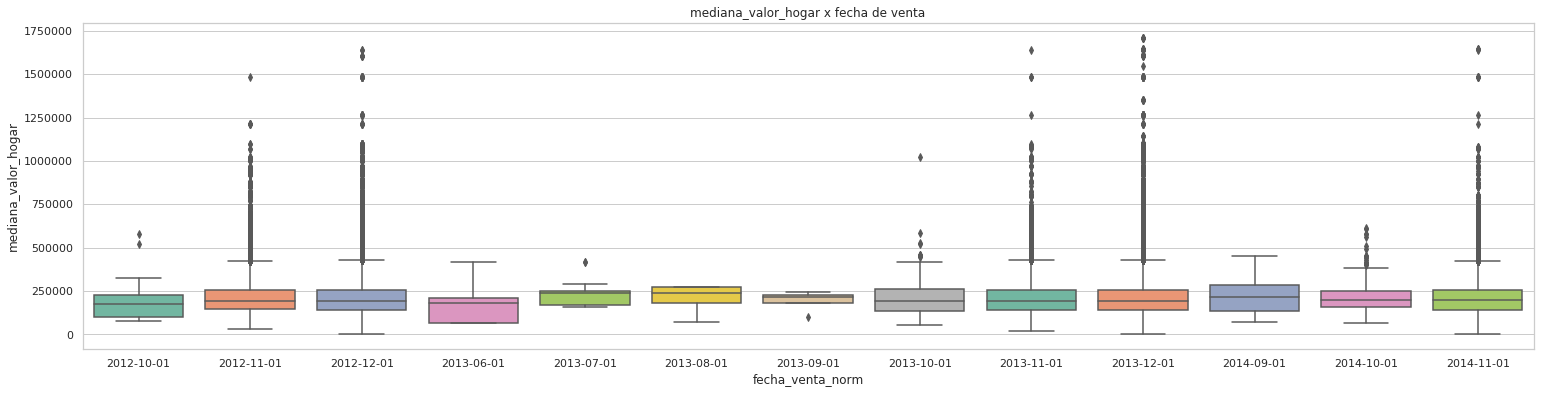

In [48]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="mediana_valor_hogar", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("mediana_valor_hogar x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### Edades %
- Se observa que las distribucion de todos los rangos de edades se mantienen entre 7 y 9 %.
- Los de edad longeava son los que poseen valores de distribucion mas bajo
- LOs outliers deben corresponder a zonas donde la distribucion de edades en esos rangos es mayor. La mayoria se observa en los rangos de edad joven.

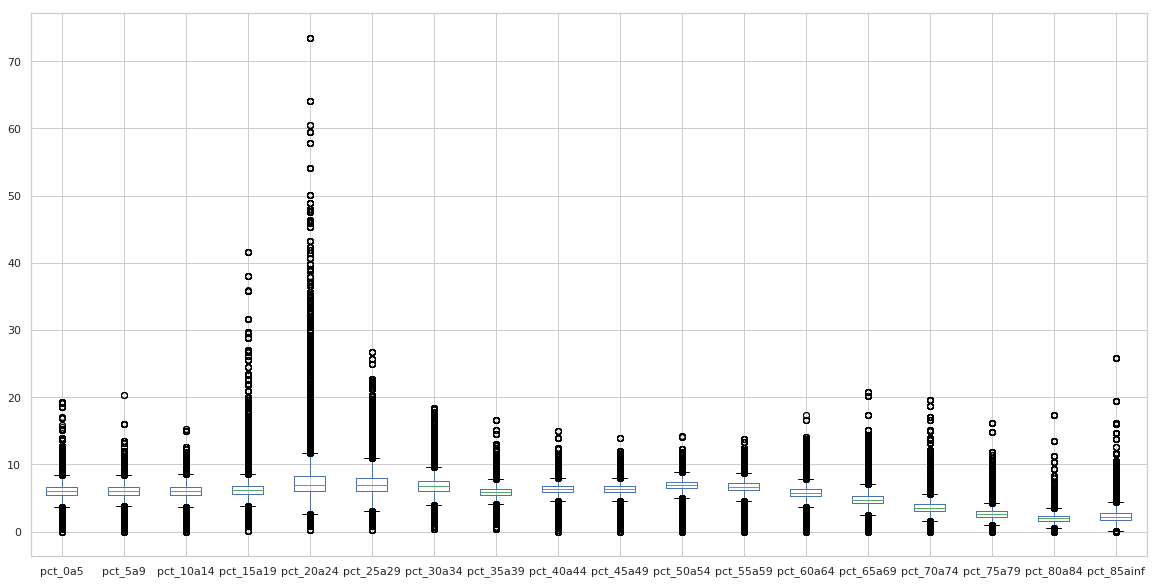

In [75]:
plt.figure(figsize=(20, 10))
rawdata.boxplot(column=['pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf'])
pass

#### id_pos
- La mayoria de los pos de ventas han realizado un numero de cantidad de ventas menor a 20 en el universo de estudio.
- No hay un numero de transacciones de ventas equitativo entre todos los pos de ventas.

In [24]:
pos_aggr = rawdata.groupby('id_pos').size().reset_index()
pos_aggr.columns = ['id_pos','numreg']

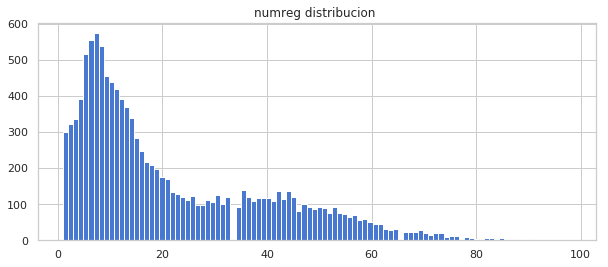

In [26]:
plt.figure(figsize=(10, 4))
simpleHistGraph('numreg',pos_aggr, bins=100)

In [20]:
pos_aggr = rawdata.groupby('fecha_venta_norm').id_pos.nunique().reset_index()

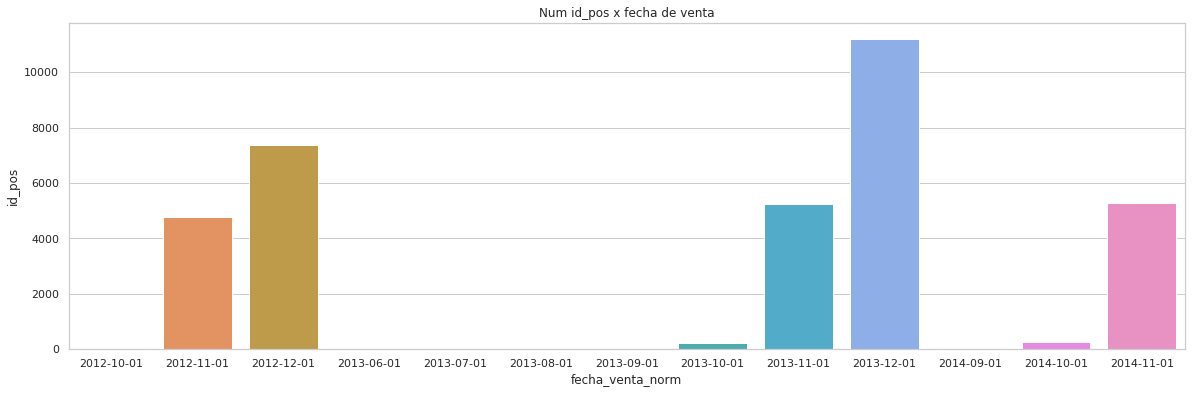

In [24]:
plt.figure(figsize=(20, 6))

ax = sns.barplot(x="fecha_venta_norm", y="id_pos", data=pos_aggr)
ax.set_title("Num id_pos x fecha de venta")
pass


In [ ]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, money)
plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.show()

In [27]:
rawdata.groupby('id_pos').size().sort_values(ascending=False).head(20)

id_pos
4369    98
3683    95
4695    93
4619    91
4761    91
3735    91
7625    90
5499    90
3344    89
6926    89
4775    88
6398    88
6677    87
7609    87
6284    87
5369    85
3692    85
6246    85
6052    85
4667    85
dtype: int64

<Figure size 1296x1296 with 0 Axes>

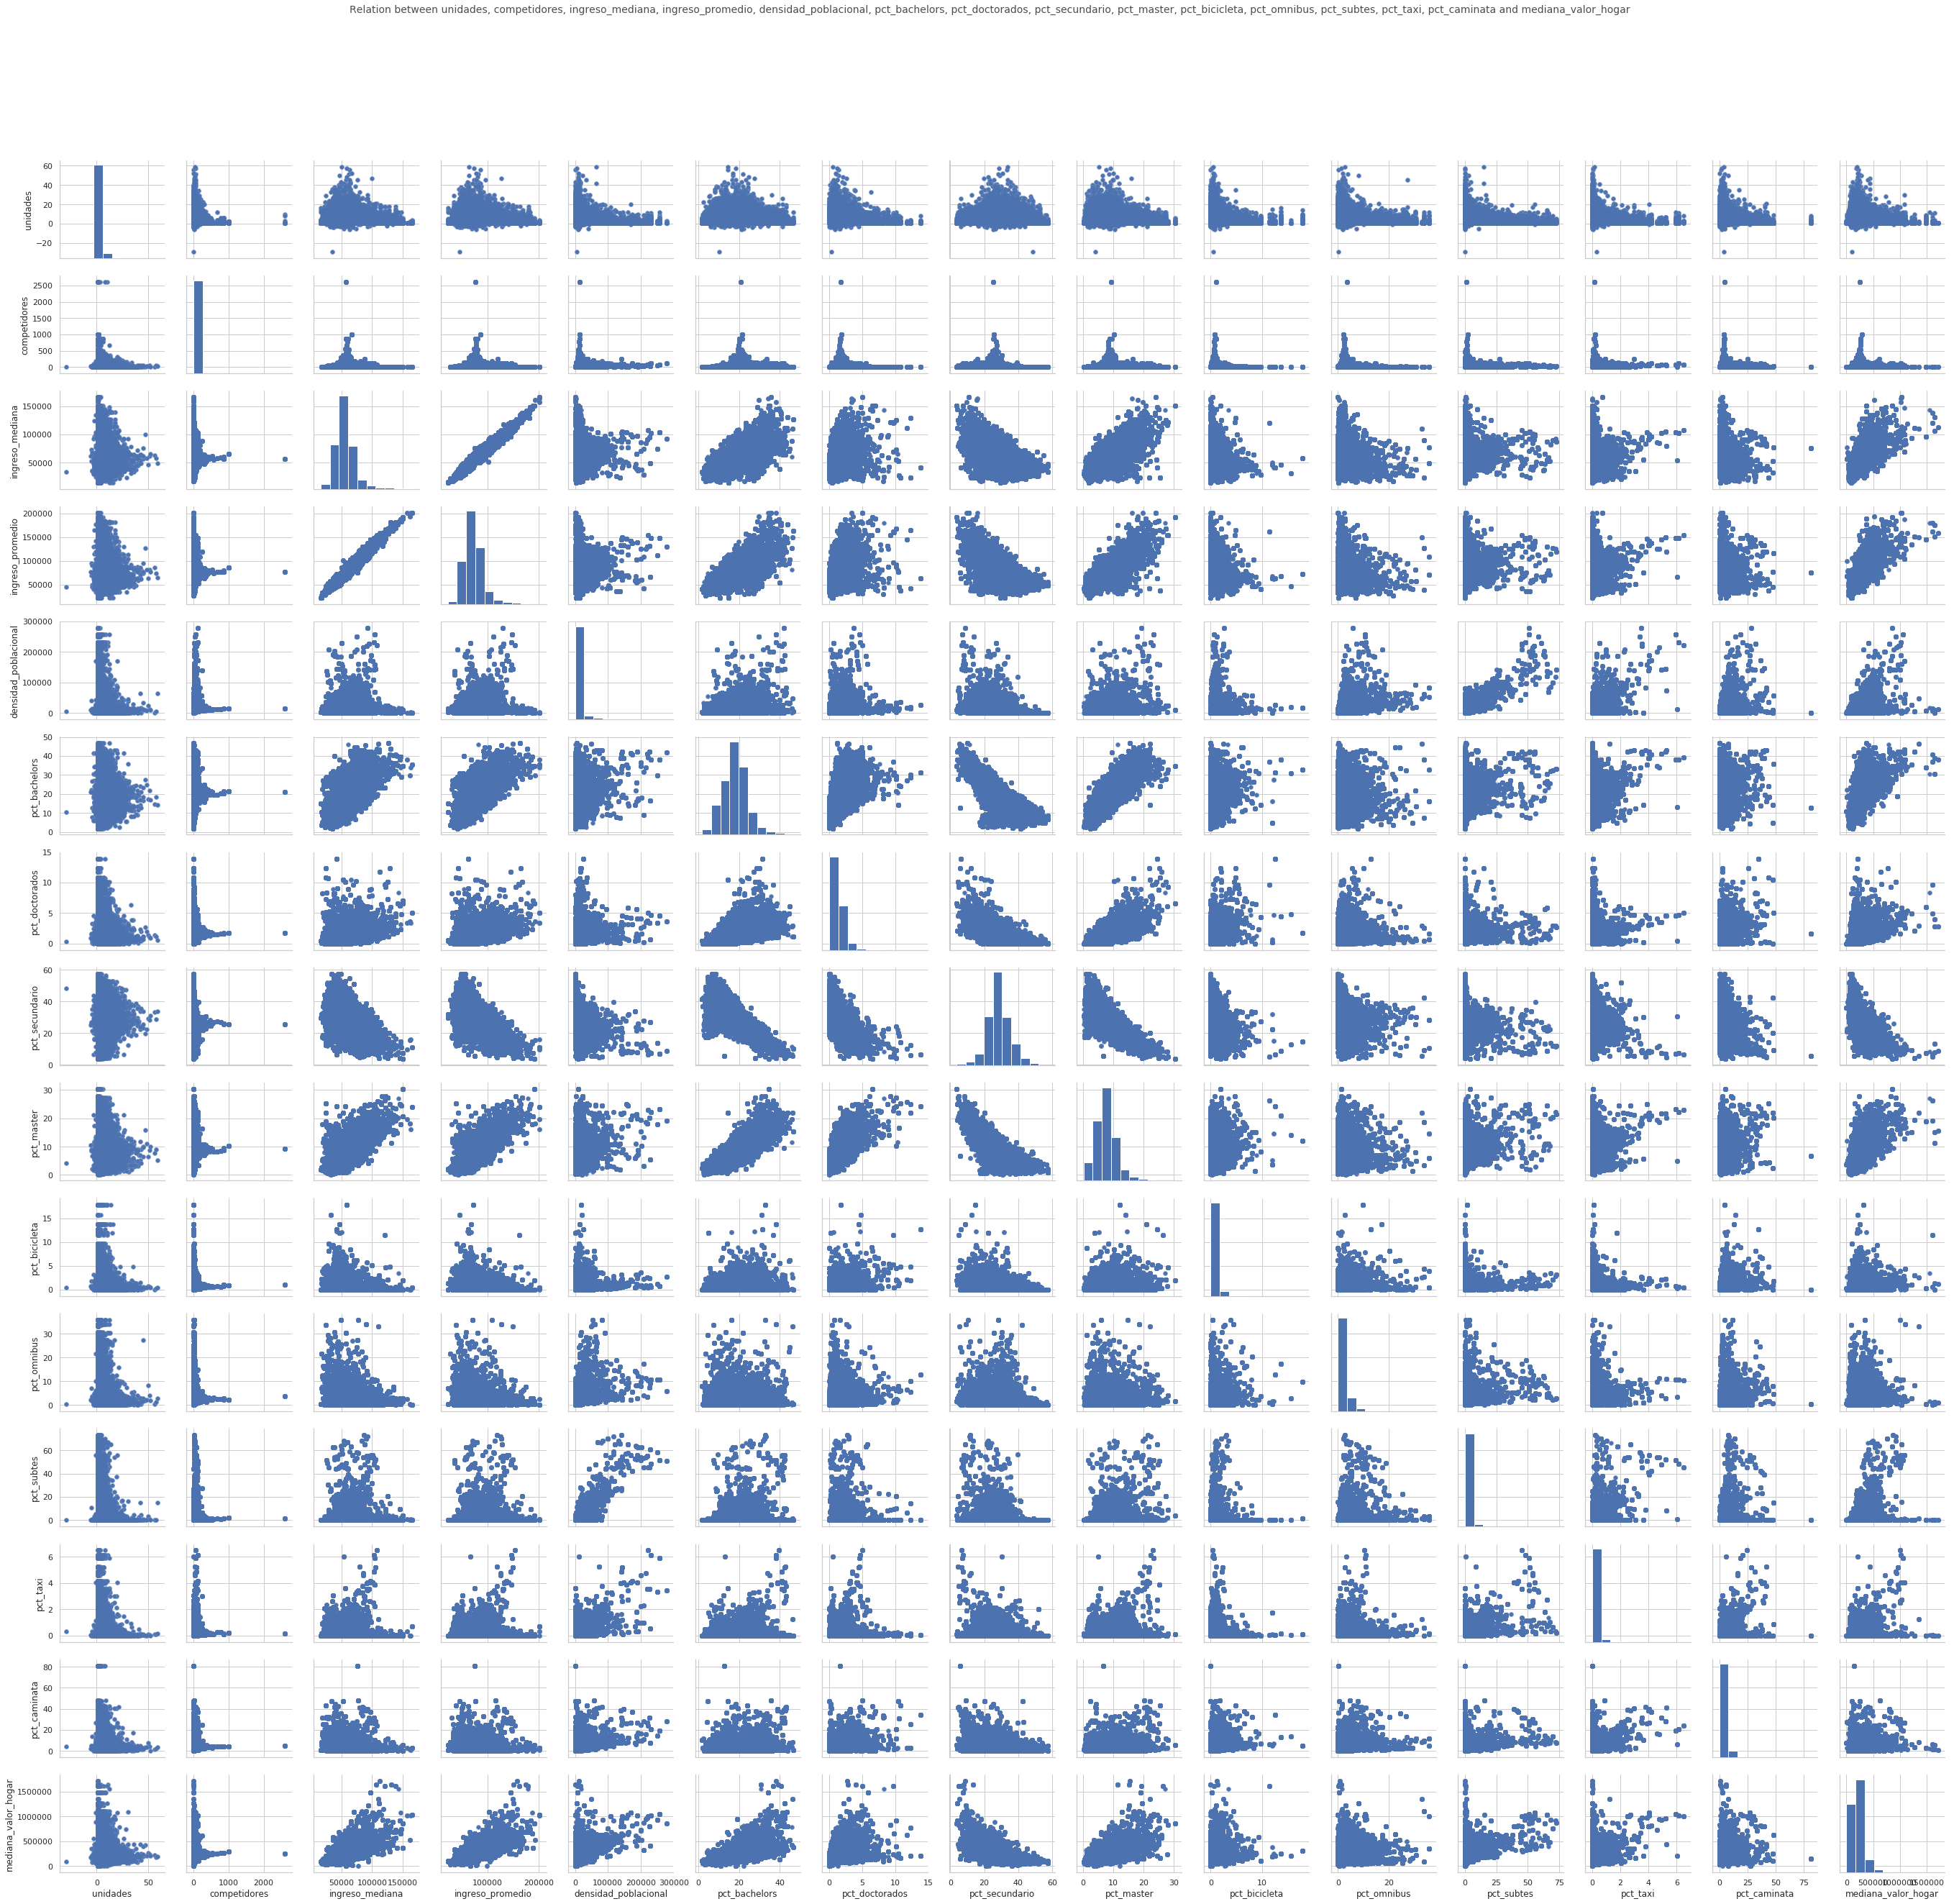

In [54]:
# =================================================
#  Scatterplot Matrix (Scatterplot + distribution)
# =================================================

var = ['unidades', 'competidores',
       'ingreso_mediana', 'ingreso_promedio', 'densidad_poblacional','pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar'] # put all the numeric vars to analyze + target (or categoical value used in hue) 
         # exp: ["numvar1", "numvar2",.. "numvarn", target]
         # Note: drop null values with dropna function.
        
plt.figure(figsize=(18, 18))
g = sns.pairplot(rawdata[var], 
                  palette = colors,
                                           # will also have different scatterplot markers.
                 kind='scatter' # 'scatter' or 'reg' Kind of plot for the non-identity relationships.
                 )


# To change the size of the scatterpoints in graph
g = g.map_offdiag(plt.scatter,  s=35,alpha=0.5)

# remove the top and right line in graph
sns.despine()

# Additional line to adjust some appearance issue
plt.subplots_adjust(top=0.9)

# Set the Title of the graph from here
g.fig.suptitle('Relation between ' + ', '.join([s  for s in var[:len(var)-1]]) + ' and ' + var[len(var)-1],
	fontsize=14,color="black",alpha=0.7)

pass

In [ ]:
# =======================================
#  Scater plot + distribution + line reg
#  2 numerical vars
# =======================================
plt.figure(figsize=(12,12))
sns.jointplot("var1", "var2", data=rawdata, kind="reg", annot_kws=dict(stat="r"))
pass

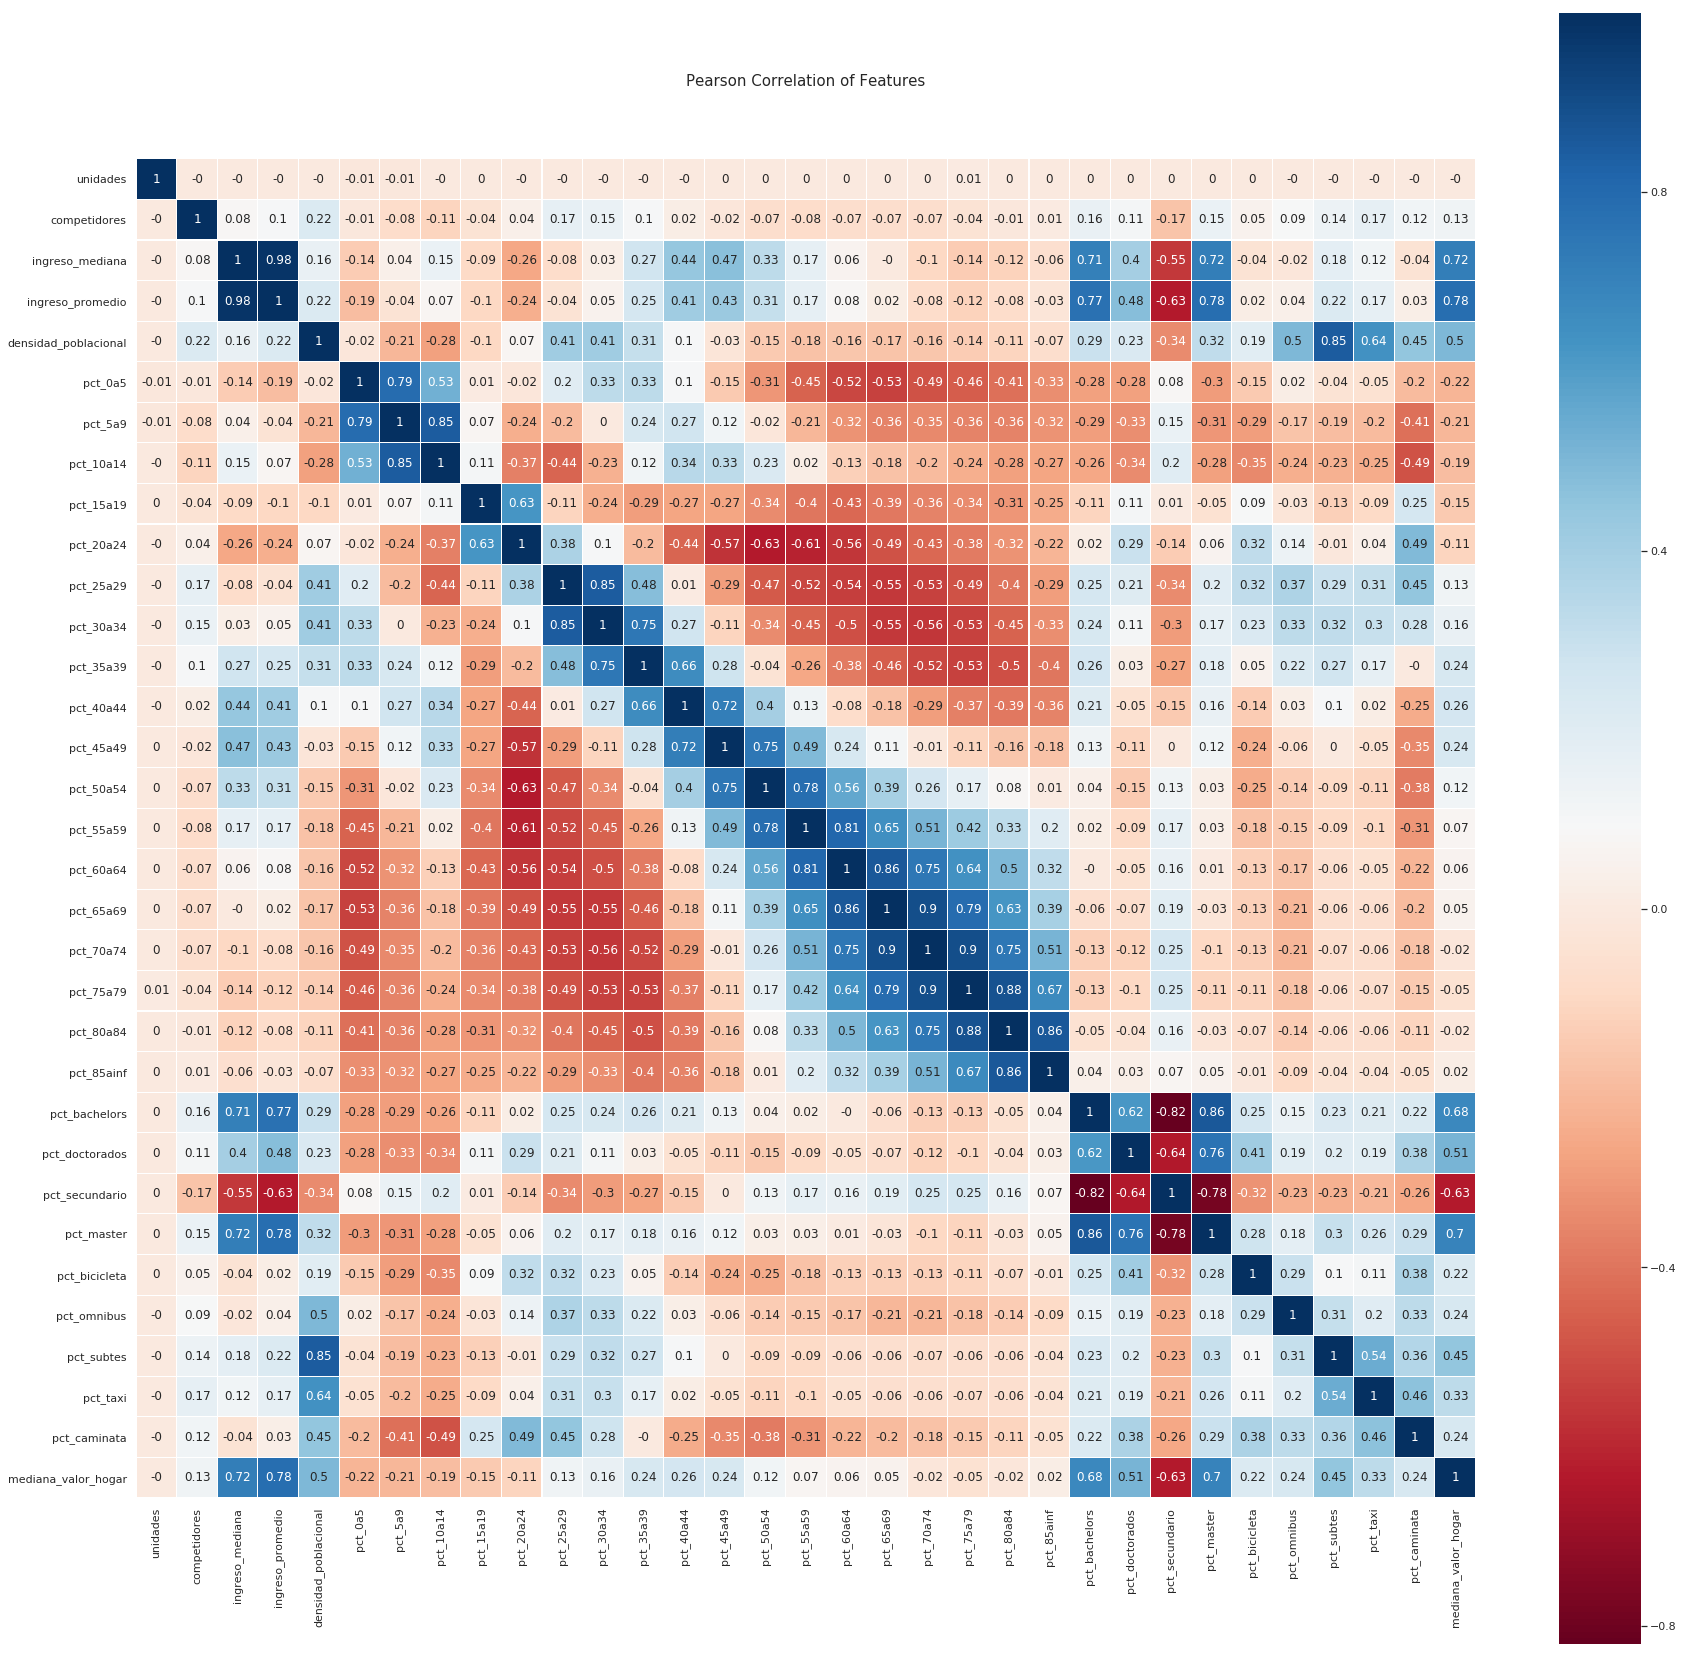

In [52]:
# ====================
#  HeatMap Correlation
# ====================

# select only numerical data. Drop or replace null values
col_names = ['unidades', 'competidores',
       'ingreso_mediana', 'ingreso_promedio', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar']
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(rawdata[col_names].astype(float).corr().round(2), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
pass

### Missing value analysis

In [76]:
# To check if there are any null values in the dataset
rawdata.isnull().values.any() 

True

In [77]:
rawdata.isnull().sum()

fecha_venta               0
id_pos                    0
unidades                  0
canal                     0
competidores            557
ingreso_mediana          10
ingreso_promedio         10
densidad_poblacional     18
pct_0a5                   0
pct_5a9                  18
pct_10a14                25
pct_15a19                 0
pct_20a24                18
pct_25a29                18
pct_30a34                18
pct_35a39                18
pct_40a44                18
pct_45a49                18
pct_50a54                18
pct_55a59                18
pct_60a64                18
pct_65a69                18
pct_70a74                18
pct_75a79                18
pct_80a84                18
pct_85ainf               18
pct_bachelors            18
pct_doctorados           18
pct_secundario           18
pct_master               18
pct_bicicleta            18
pct_omnibus              18
pct_subtes               18
pct_taxi                 18
pct_caminata             18
mediana_valor_hogar 

## Envios

#### Load Data

In [31]:
envios = pd.read_csv('../data/raw/envios.txt', sep='|')

### Describe Data

In [21]:
envios.shape

(42434, 4)

In [22]:
envios.head()

,fecha,id_pos,unidades_despachadas,cantidad_envios
0,2012-08-17,5235,36,1
1,2012-08-24,4611,48,1
2,2012-08-24,4645,48,1
3,2012-08-24,4649,72,1
4,2012-08-24,4677,72,1


In [23]:
envios.sample(n=5)

,fecha,id_pos,unidades_despachadas,cantidad_envios
9885,2013-08-16,8353,84,1
674,2012-10-19,13171,12,1
17700,2013-09-20,8142,24,1
37635,2014-10-18,3712,12,1
26464,2014-09-13,11106,24,1


In [24]:
envios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42434 entries, 0 to 42433
Data columns (total 4 columns):
fecha                   42434 non-null object
id_pos                  42434 non-null int64
unidades_despachadas    42434 non-null int64
cantidad_envios         42434 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [25]:
envios.describe(include=['O']) # category data

,fecha
count,42434
unique,41
top,2012-10-19
freq,9452


In [26]:
envios.describe() # numerical data

,id_pos,unidades_despachadas,cantidad_envios
count,42434.000000,42434.000000,42434.000000
mean,9453.247632,35.532827,1.000165
std,5678.198406,32.258875,0.012843
min,3142.000000,12.000000,1.000000
25%,5487.000000,12.000000,1.000000
50%,7720.500000,24.000000,1.000000
75%,12792.000000,48.000000,1.000000
max,63432.000000,528.000000,2.000000


In [27]:
print(envios.nunique())

fecha                      41
id_pos                  13449
unidades_despachadas       33
cantidad_envios             2
dtype: int64


In [32]:
envios['fecha'] = pd.to_datetime(envios['fecha'])

In [33]:
envios['fecha_norm'] = envios['fecha'].apply(lambda x : date(x.year,x.month,1))

#### unidades_despachadas

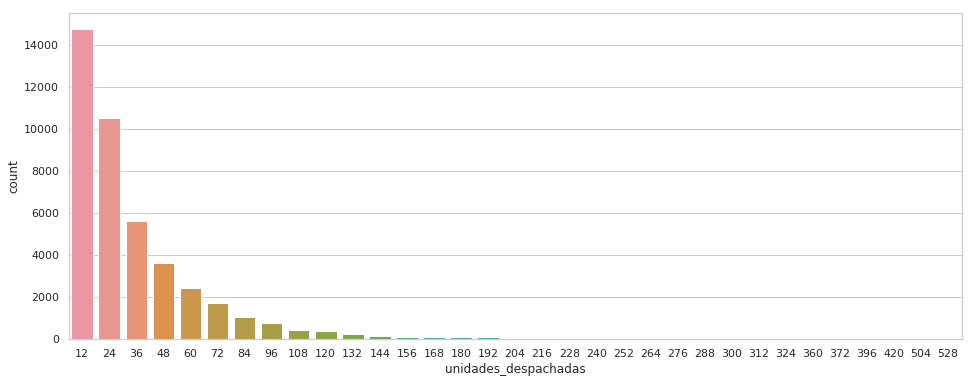

In [34]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(16, 6))
sns.countplot(x='unidades_despachadas', data=envios)
pass

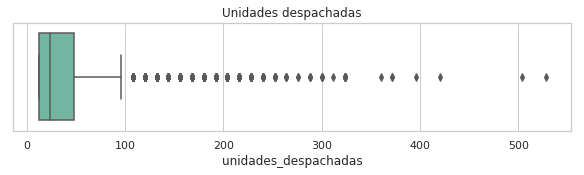

In [35]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="unidades_despachadas", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades despachadas")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

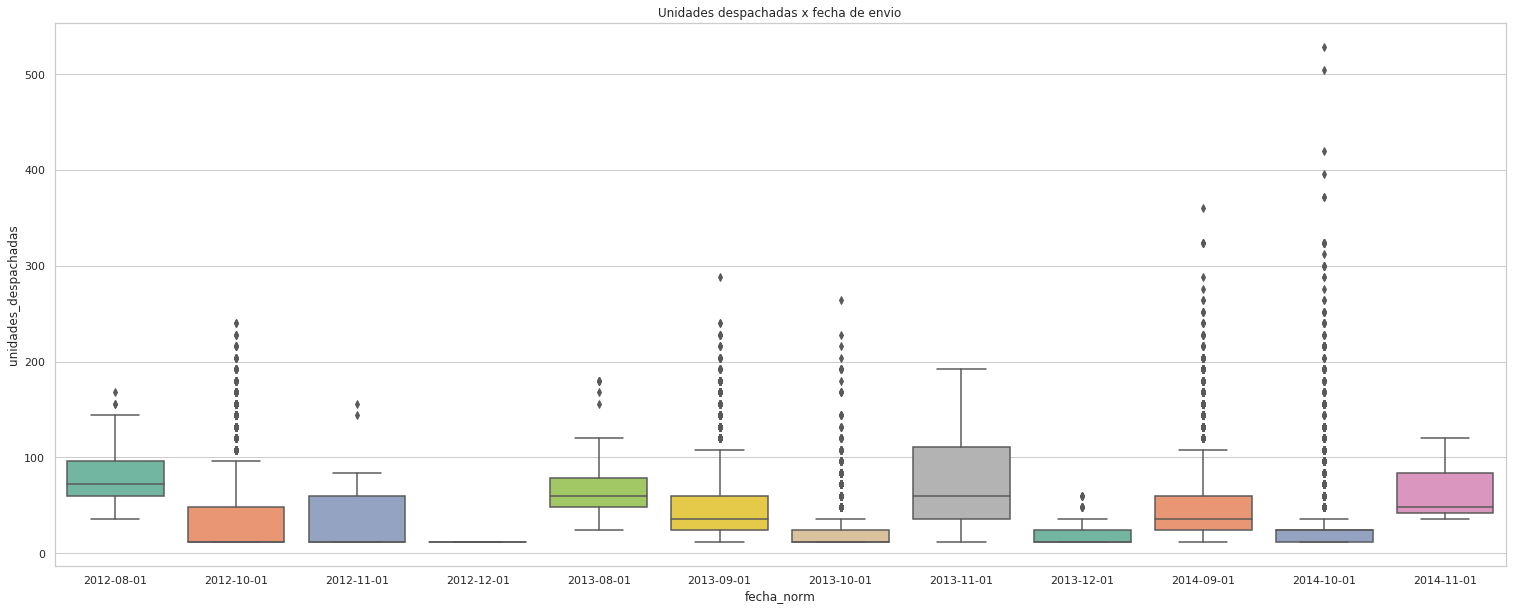

In [37]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_norm", y="unidades_despachadas", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades despachadas x fecha de envio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La mayoria de las trx ocurren en los meses anteriores a los festivos (9 y 10) de cada año. No se observa casi nada de activadad en los meses restantes


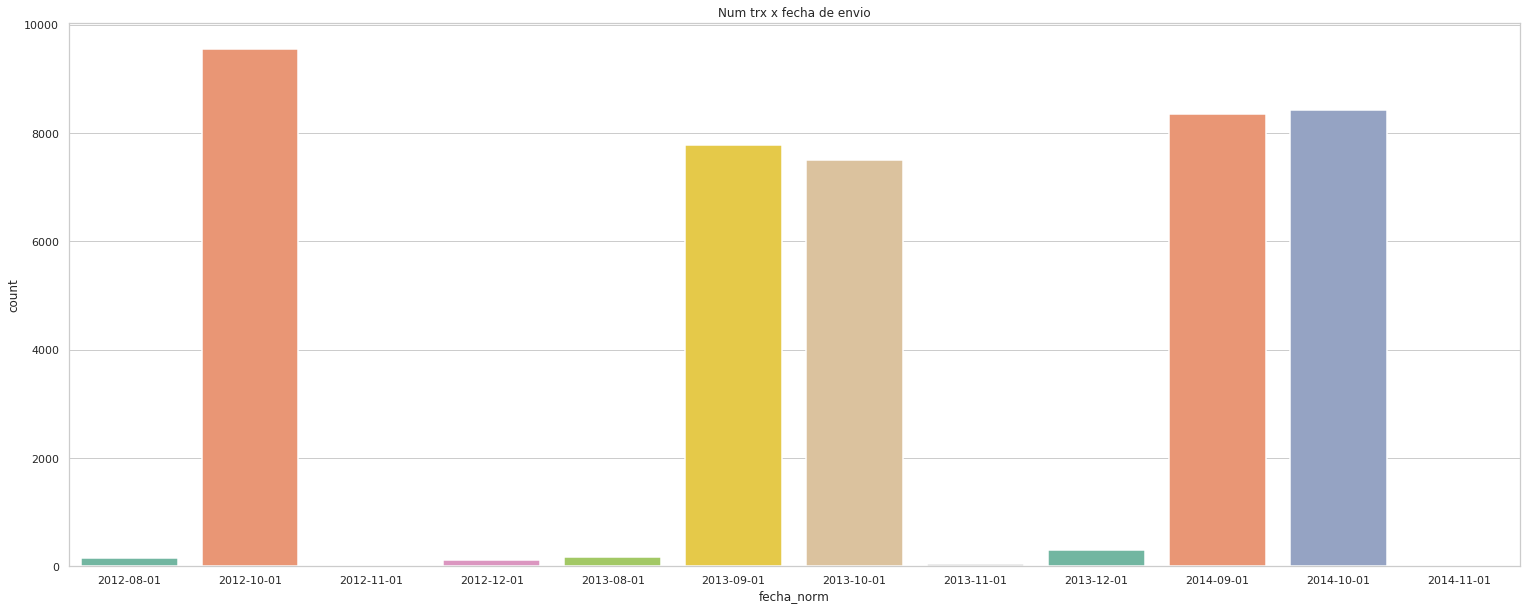

In [38]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.countplot(x="fecha_norm",           linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm'))
ax.set_title("Num trx x fecha de envio")
pass

#### cantidad_envios

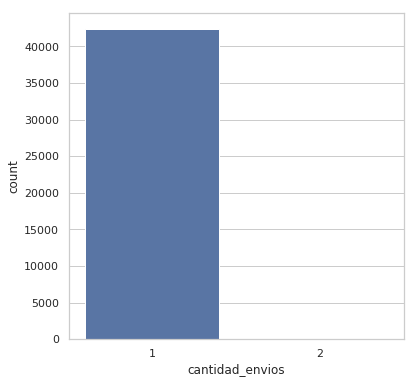

In [40]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(6, 6))
sns.countplot(x='cantidad_envios', data=envios)
pass

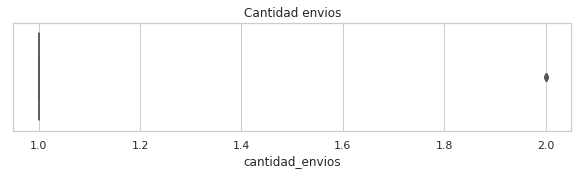

In [41]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="cantidad_envios", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios) # DataFrame, array, or list of arrays, optional
ax.set_title("Cantidad envios")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

- La mayoria de las trx ocurren en los meses anteriores a los festivos (9 y 10) de cada año. No se observa casi nada de activadad en los meses restantes


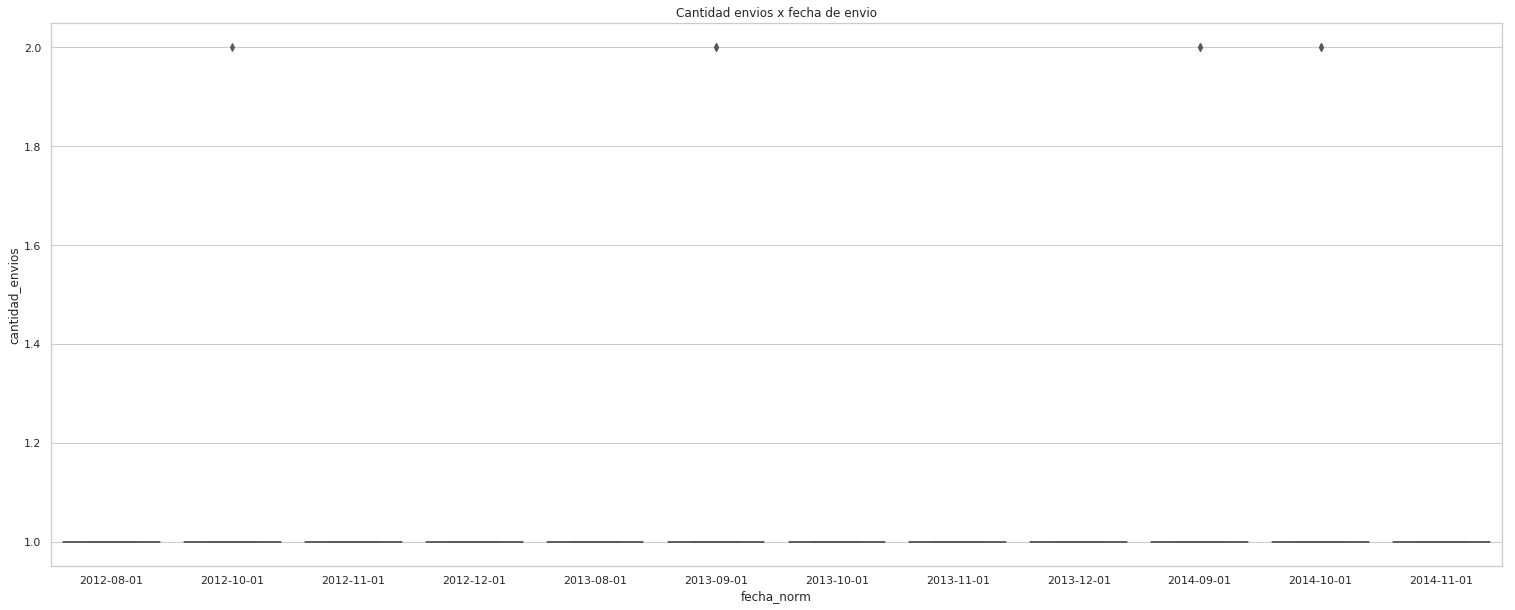

In [42]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_norm", y="cantidad_envios", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("Cantidad envios x fecha de envio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### id_pos
- La mayoria de los pos de ventas han realizado un numero de cantidad de ventas menor a 20 en el universo de estudio.
- No hay un numero de transacciones de ventas equitativo entre todos los pos de ventas.

In [43]:
pos_aggr = envios.groupby('id_pos').size().reset_index()
pos_aggr.columns = ['id_pos','numreg']

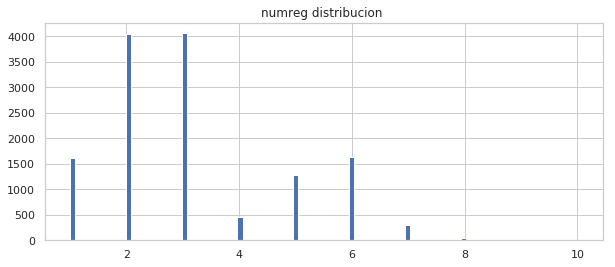

In [44]:
plt.figure(figsize=(10, 4))
simpleHistGraph('numreg',pos_aggr, bins=100)

In [45]:
envios.groupby('id_pos').size().sort_values(ascending=False).head(20)

id_pos
3566     10
3718      9
5997      9
3789      9
3921      9
4016      9
7243      8
3905      8
7919      8
3274      8
3200      8
3903      8
28141     8
4547      8
3707      8
27803     8
6667      8
3473      8
3481      8
5547      8
dtype: int64

#### Missing value analysis
- No posee valores nulos

In [46]:
# To check if there are any null values in the dataset
envios.isnull().values.any() 

False

In [47]:
envios.isnull().sum()

fecha                   0
id_pos                  0
unidades_despachadas    0
cantidad_envios         0
fecha_norm              0
dtype: int64

### Explore Categorical Data

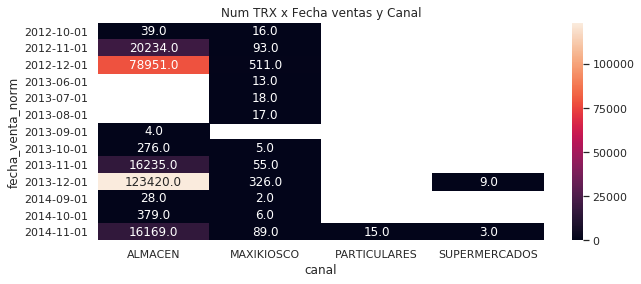

In [64]:
plt.figure(figsize=(10,4))
df = rawdata.pivot_table(index='fecha_venta_norm', columns='canal', 
                         values='unidades', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num TRX x Fecha ventas y Canal")
plt.show()

In [53]:
rawdata['year'] = rawdata.fecha_venta.dt.year
rawdata['month'] = rawdata.fecha_venta.dt.month


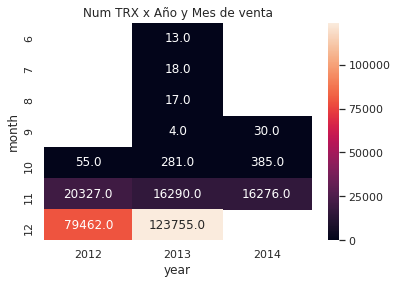

In [63]:
plt.figure(figsize=(6,4))
df = rawdata.pivot_table(index='month', columns='year', 
                         values='unidades', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num TRX x Año y Mes de venta")
plt.show()

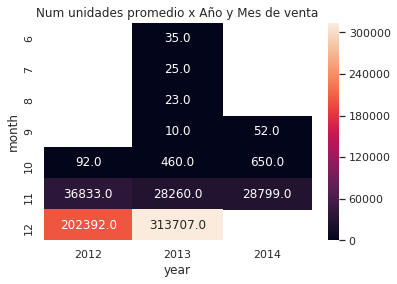

In [68]:
plt.figure(figsize=(6,4))
df = rawdata.pivot_table(index='month', columns='year', 
                         values='unidades', 
                         aggfunc=np.sum) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num unidades totales x Año y Mes de venta")
plt.show()